In [1]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import LineString
import json
from tqdm.notebook import tqdm
tqdm.pandas()

import math

%matplotlib inline

* <font color="green">**jak czasy przejazdu po trasach maja sie do godzin szczytowych vs luznych**</font>
* <font color="green">**zależność czasów przejazdu i prędkości autobusów od umiejscowienia na mapie wrocławia**</font>
* <font color="green">**zależność opóźnień od umiejscowienia na mapie wrocławia**</font>
* <font color="green">**wytrenowac model przewidujący opóźnienia (wagi krawędzi w grafie)**</font>

* <font color="red">czy daloby sie wykryc odcinki, gdzie autobus moglby nadrobic spoznienia?</font>
* <font color="red">jak dlugo autobus jechal miedzy przystankami w stosunku do tego ile faktycznie moglby jechac</font>
* <font color="red">wyrysowanie awarii w poszczegolnych rejonach wroclawia</font>

---
# **Gathering data**

We obtain data from Overpass (http://overpass-turbo.eu/) using following querry:

```
[out:json][timeout:25];
(
  area['name'='Wrocław'];
  //(node['railway'='tram_stop'](area););
  //(node['highway'='bus_stop'](area););
  (relation['route'='tram'](area);); // dla linii tramwajowych
  (relation['route'='bus'](area);); // dla linii autobusowych
);
out body;
>;
out skel qt;wroc = ox.geocode_to_gdf("Wrocław, Poland", which_result=1)
```

### Wroclaw road graph

In [2]:
roads_graph = ox.graph_from_place(
    "Wrocław, Poland", 
    network_type="drive",
)

### **Wrocław open data**

In [3]:
routes_od = pd.read_csv("dane/routes.txt")
stops_od = pd.read_csv("dane/stops.txt")
shapes_od = pd.read_csv("dane/shapes.txt")
trips_od = pd.read_csv("dane/trips.txt")
stop_times_od = pd.read_csv("dane/stop_times.txt")

stops_od = gpd.GeoDataFrame(stops_od, geometry=gpd.points_from_xy(stops_od.stop_lon.values, stops_od.stop_lat.values), crs='WGS84').drop(["stop_lat", "stop_lon"], axis=1)

stops_od.rename(columns={"stop_name": "name"}, inplace=True)
stops_od['geometry'] = [Point(round(el, 3) for el in p.coords[0]) for p in stops_od.geometry.values]
stops_od['coords'] = [p.coords[0] for p in stops_od.geometry.values]

shapes_od = gpd.GeoDataFrame(shapes_od, geometry=gpd.points_from_xy(shapes_od.shape_pt_lon.values, shapes_od.shape_pt_lat.values), crs='WGS84').drop(["shape_pt_lat", "shape_pt_lon"], axis=1)

routes = pd.read_csv("routes_df.csv")

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### **OSMNX**

In [4]:
bus_stops_ox = ox.geometries_from_place("Wrocław, Poland", tags={'highway': 'bus_stop'}).loc['node']
bus_stops_ox.drop('name', axis=1, inplace=True)

tram_stops_ox = ox.geometries_from_place("Wrocław, Poland", tags={'railway': 'tram_stop'}).loc['node']
tram_stops_ox.drop('name', axis=1, inplace=True)

wroc = ox.geocode_to_gdf("Wrocław, Poland")

### **Overpass**

In [6]:
tram_op = gpd.read_file("dane/tram.geojson")
bus_op = gpd.read_file("dane/bus.geojson")

tram_op = tram_op[tram_op.within(wroc.iloc[0].geometry.buffer(0.05))]
bus_op = bus_op[bus_op.within(wroc.iloc[0].geometry.buffer(0.05))]

bus_stops_op = bus_op[bus_op['route'] != 'bus'].dropna(axis=1, how='all')
bus_stops_op['osmid'] = [int(el.split("/")[1]) for el in bus_stops_op['id']]
bus_stops_op.drop(['id', '@id'], axis=1, inplace=True)
bus_routes_op = bus_op[bus_op['route'] == 'bus']

tram_stops_op = tram_op[tram_op['route'] != 'tram'].dropna(axis=1, how='all')
tram_stops_op['osmid'] = [int(el.split("/")[1]) for el in tram_stops_op['id']]
tram_stops_op.drop(['id', '@id'], axis=1, inplace=True)
tram_routes_op = tram_op[tram_op['route'] == 'tram']

## Merging data from all sources

### Bus

In [7]:
bus_stops_ox['osmid'] = bus_stops_ox.index.values
bus_stops_ox['coords'] = [p.coords[0] for p in [Point(round(el, 3) for el in p.coords[0]) for p in bus_stops_ox.geometry.values]]

bus_stops_final = bus_stops_ox.merge(stops_od.drop('geometry', axis=1), on="coords")[['osmid', 'stop_id', 'stop_code', 'name', 'geometry']]

### Tram

In [8]:
tram_stops_ox['osmid'] = tram_stops_ox.index.values
tram_stops_ox['coords'] = [p.coords[0] for p in [Point(round(el, 3) for el in p.coords[0]) for p in tram_stops_ox.geometry.values]]

tram_stops_final = tram_stops_ox.merge(stops_od.drop('geometry', axis=1), on="coords")[['osmid', 'stop_id', 'stop_code', 'name', 'geometry']]

## Changing CRS

In [9]:
wroc.to_crs(crs='EPSG:3395', inplace=True)
stops_od.to_crs(crs='EPSG:3395', inplace=True)

bus_routes_op.to_crs(crs='EPSG:3395', inplace=True)
bus_stops_ox.to_crs(crs='EPSG:3395', inplace=True)
bus_stops_op.to_crs(crs='EPSG:3395', inplace=True)
bus_stops_final.to_crs(crs='EPSG:3395', inplace=True)

tram_routes_op.to_crs(crs='EPSG:3395', inplace=True)
tram_stops_ox.to_crs(crs='EPSG:3395', inplace=True)
tram_stops_op.to_crs(crs='EPSG:3395', inplace=True)
tram_stops_final.to_crs(crs='EPSG:3395', inplace=True)

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---

# **Creating routes dataframe (all trip times)**

The datafrane consists of:
* **`trip_id`** - ID of a trip (a value from Wroclaw Open Data source) a single trip means buses travel from one stop to another at specific hour/minute
* **`source_stop_id`** - ID of source stop (not osmid)
* **`target_stop_id`** - ID of target stop (not osmid)
* **`source-target`** - created with `source_stop_id` and `target_stop_id` (for later use)
* **`duration`** - trip duration (in seconds). The time between bus arrival at next stop and previous stop 
* **`direction`** - trip direction (binary value)
* **`route_id`** - ID of a route (a bus/tram line, e.g. 1, 2, 4, 10, ... for trams or 145, 146, 255, .. for buses) 
* **`time`** - the time of trip (the absolute time in HH:MM:SS format)
* **`hour`** - hour taken from `time` columns (for later use)
* **`source_geometry`** - coordinates of source stop
* **`target_geometry`** - coordinates of target stop
* **`geometry`** - midpoint between `source_geometry` and `target_geometry`
* **`line_distance`** - distance between `source_geometry` and `target_geometry` (in straight line)
* **`line_velocity`** - velocity of a bus measured using `line_distance` and `duration`

In [687]:
trips_times = stop_times_od.merge(trips_od, on='trip_id')

arrival_hours = np.array([int(t.split(":")[0]) for t in trips_times['arrival_time'].values])
arrival_minutes = np.array([int(t.split(":")[1]) for t in trips_times['arrival_time'].values])

departure_hours = np.array([int(t.split(":")[0]) for t in trips_times['departure_time'].values])
departure_minutes = np.array([int(t.split(":")[1]) for t in trips_times['departure_time'].values])

trips_times['arrival_time'] = [f"{str(hour % 24).zfill(2)}:{str(minute).zfill(2)}:00" for hour, minute in zip(arrival_hours, arrival_minutes)]
trips_times['departure_time'] = [f"{str(hour % 24).zfill(2)}:{str(minute).zfill(2)}:00" for hour, minute in zip(departure_hours, departure_minutes)]

from tqdm.notebook import tqdm

unique_trips = trips_times['trip_id'].unique()

routes = []

for trip in tqdm(unique_trips):
    trip_times = trips_times[trips_times['trip_id'] == trip] 
    trip_times['arrival_time'] = pd.to_datetime(trip_times['arrival_time']).values
    trip_times['departure_time'] = pd.to_datetime(trip_times['departure_time']).values
    for first_stop, second_stop in zip(trip_times[:-1].iterrows(), trip_times[1:].iterrows()):
        first_stop = first_stop[1]
        second_stop = second_stop[1]
        start_time = first_stop['departure_time']
        end_time = second_stop['arrival_time']
        duration = (end_time - start_time).seconds
        routes.append({
            'trip_id': trip,
            'source_stop_id': first_stop['stop_id'],
            'target_stop_id': second_stop['stop_id'],  
            'duration': duration,
            'direction': first_stop['direction_id'],
            'route_id': first_stop['route_id'],
            'time': start_time.time(),
        })
        
routes_df = pd.DataFrame.from_dict(routes)

routes_df['hour'] = routes_df['time'].apply(lambda x: x.hour)
routes_df['source-target'] = routes_df[['source_stop_id', 'target_stop_id']].apply(lambda x: f"{x['source_stop_id']}-{x['target_stop_id']}", axis=1)

routes_df.to_csv("routes_df.csv", index=False)

  0%|          | 0/40378 [00:00<?, ?it/s]

/tmp/ipykernel_46/247915293.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_times['arrival_time'] = pd.to_datetime(trip_times['arrival_time'])
/tmp/ipykernel_46/247915293.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_times['departure_time'] = pd.to_datetime(trip_times['departure_time'])


## Adding line distance, velocity and geometry (as midpoint)

In [15]:
def add_velocity_and_distance(row):
    duration = row['duration']
    start_point = row['source_geometry']
    end_point = row['target_geometry']
    line_distance = start_point.distance(end_point)
    line_velocity = line_distance / (duration / 60 / 60) / 1000 if duration > 0 else 60
    mid_x = (start_point.coords[0][0] + end_point.coords[0][0]) / 2
    mid_y = (start_point.coords[0][1] + end_point.coords[0][1]) / 2
    midpoint = Point(mid_x, mid_y)
    row['line_distance'] = line_distance
    row['line_velocity'] = line_velocity
    row['geometry'] = midpoint
    return row

routes_df = routes_df \
    .merge(stops_od.rename(columns={'stop_id': 'target_stop_id'})[['target_stop_id', 'geometry']], on='target_stop_id') \
    .rename(columns={'geometry': 'target_geometry'}) \
    .merge(stops_od.rename(columns={'stop_id': 'source_stop_id'})[['source_stop_id', 'geometry']], on='source_stop_id') \
    .rename(columns={'geometry': 'source_geometry'})

routes_df = routes_df.progress_apply(add_velocity_and_distance, axis=1)
routes_df.to_csv("routes_df.csv", index=False)

## Load routes_df

In [10]:
routes_df = pd.read_csv("routes_df.csv")
routes_df['duration'] = routes_df['duration']*60 # minutes into seconds

routes_df['source_geometry'] = routes_df['source_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))
routes_df['target_geometry'] = routes_df['target_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))
routes_df['geometry'] = routes_df['geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
# **Creating graph using info from Wrocław open data**

The graph is created using *Wroclaw Open Data* source and `routes_df` dataframe:
* nodes features:
    * **`x`** - x coordinate of stop geometry
    * **`y`** - y coordinate of stop geometry
    * **`osmid`** - ID of a stop taken from OSM
* edges featrues:
    * * **`u`** - source stop `osmid`
    * **`v`** - target stop `osmid`
    * **`key`** - 0 for all
    * **`source_stop_id`** - ID of source stop (not osmid)
    * **`target_stop_id`** - ID of target stop (not osmid)
    * **`duration`** - trip duration (in seconds). The time between bus arrival at next stop and previous stop 
    * **`geometry`** - LineString object created using `source_geometry` and `target_geometry`
    * **`line_distance`** - distance between source_geometry and target_geometry (in straight line)

## nodes

In [9]:
from copy import deepcopy

temp_stops_df = deepcopy(pd.concat([bus_stops_final, tram_stops_final]))

stops_nodes = gpd.GeoDataFrame(temp_stops_df[['geometry', 'osmid', 'stop_id']])
stops_nodes['x'] = [p.coords[0][0] for p in temp_stops_df.geometry.values]
stops_nodes['y'] = [p.coords[0][1] for p in temp_stops_df.geometry.values]
stops_nodes.set_index('osmid', inplace=True)
stops_nodes.to_crs(crs='EPSG:3395', inplace=True)

## edges

In [11]:
mean_routes_df = routes_df.drop(['direction', 'hour', 'source_stop_id', 'target_stop_id'], axis=1).groupby(['source-target']).mean() \
    .merge(routes_df[['source-target', 'source_geometry', 'target_geometry']], on=['source-target']) \
    .astype(str) \
    .drop_duplicates().reset_index(drop=True)

mean_routes_df['source_geometry'] = mean_routes_df['source_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))
mean_routes_df['target_geometry'] = mean_routes_df['target_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))

mean_routes_df['duration'] = mean_routes_df['duration'].astype(float)
mean_routes_df['line_velocity'] = mean_routes_df['line_velocity'].astype(float)
mean_routes_df['line_distance'] = mean_routes_df['line_distance'].astype(float)

rows = []
for edge in mean_routes_df.iterrows():
    edge = edge[1]
    source, target = np.array(edge['source-target'].split("-"), int)
    if source in stops_nodes['stop_id'].values and target in stops_nodes['stop_id'].values:
        source = temp_stops_df[temp_stops_df['stop_id'] == source].iloc[0]
        target = temp_stops_df[temp_stops_df['stop_id'] == target].iloc[0]
        start_point, end_point = edge['source_geometry'], edge['target_geometry']
        rows.append({
            'u': source['osmid'],
            'v': target['osmid'],
            'line_distance': edge['line_distance'],
            'line_velocity': edge['line_velocity'],
            'geometry': LineString([start_point.coords[0], end_point.coords[0]]),
            'source_stop_id': source['stop_id'],
            'target_stop_id': target['stop_id'],
            "duration": edge['duration'],
            "key": 0
        })
        
stops_edges = gpd.GeoDataFrame.from_dict(rows, crs='EPSG:3395').set_index(['u', 'v', 'key'])

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:475: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  return GeoDataFrame(dataframe, geometry=geometry, crs=crs)


## graph

In [12]:
G = ox.graph_from_gdfs(
    stops_nodes.drop('stop_id', axis=1).drop_duplicates(),
    stops_edges
)

---
# **Recorded trips (using python script)**

## Making it the same as routes_df

### Parsing str duration to seconds, changing column names, etc.

In [12]:
def parse_str_duration_to_seconds(duration):
    minutes, seconds = duration.split(':')[1:]
    minutes, seconds = float(minutes), float(seconds)
    return minutes*60 + seconds


recorded_trips = pd.read_csv("data/recorded_trips.csv", index_col=0)
recorded_trips['time'] = [start_time.split('+')[0].split(' ')[1] for start_time in recorded_trips['start_time'].values] # chcemy tylko godziny i minuty
recorded_trips['hour'] = [int(time.split(':')[0]) for time in recorded_trips['time']]
recorded_trips = recorded_trips.rename(columns={'destination_id': 'target_code', 'source_id': 'source_code'}).dropna()
recorded_trips['source_code'] = recorded_trips['source_code'].astype(int)
recorded_trips['target_code'] = recorded_trips['target_code'].astype(int)
recorded_trips = recorded_trips[~recorded_trips['duration'].str.contains('-')] # usuwamy -1 days, do naprawyy
recorded_trips['duration'] = recorded_trips['duration'].apply(parse_str_duration_to_seconds) # zamieniamy stringi na sekundy
recorded_trips = recorded_trips.drop(['source_name', 'destination_name', 'line', 'k', 'likely_incorrect', 'start_time', 'end_time'], axis=1)

recorded_trips = recorded_trips.merge(
    stops_od[['stop_code', 'geometry', 'stop_id']].rename(columns={'stop_code': 'source_code'}), 
    on="source_code"
).rename(columns={'geometry': 'source_geometry', 'stop_id': 'source_stop_id'})

recorded_trips = recorded_trips.merge(
    stops_od[['stop_code', 'geometry', 'stop_id']].rename(columns={'stop_code': 'target_code'}), 
    on="target_code"
).rename(columns={'geometry': 'target_geometry', 'stop_id': 'target_stop_id'})

recorded_trips = recorded_trips.drop(['source_code', 'target_code'], axis=1)
recorded_trips['source-target'] = recorded_trips[['source_stop_id', 'target_stop_id']].apply(lambda x: f"{x['source_stop_id']}-{x['target_stop_id']}", axis=1)

### Adding line distance, velocity and midpoint geometry

In [16]:
recorded_trips = recorded_trips.progress_apply(add_velocity_and_distance, axis=1)

  0%|          | 0/158457 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


---

# **Final data preparation**

## Delete highest values (some outliers?)

In [17]:
_routes_df = routes_df[routes_df['duration'] <= 540]
_recorded_trips = recorded_trips[recorded_trips['duration'] <= 540]

## Create delay dataframes

### Daily delays

In [54]:
unique_recorded_trips = _recorded_trips['source-target'].unique()
unique_scheduled_trips = _routes_df['source-target'].unique()

common_trips = np.array(list(set(unique_recorded_trips).intersection(set(unique_scheduled_trips))))

daily_scheduled_trips = _routes_df.groupby(['source-target']).mean().loc[common_trips]
daily_recorded_trips = _recorded_trips.groupby(['source-target']).mean().loc[common_trips]

daily_delays = pd.DataFrame(daily_recorded_trips['duration'] - daily_scheduled_trips['duration']) \
    .reset_index() \
    .merge(routes_df[['source-target', 'geometry']], on='source-target') \
    .drop_duplicates('source-target') \
    .reset_index(drop=True) \
    .rename(columns={'duration': 'delay'})

### Hourly delays

In [111]:
planned_trips = _routes_df[['duration', 'hour', 'source-target']]
planned_trips = planned_trips.groupby(['hour', 'source-target']).mean().reset_index()

real_trips = _recorded_trips[['duration', 'hour', 'source-target']]
real_trips = real_trips.groupby(['hour', 'source-target']).mean().reset_index()

merged = pd.merge(planned_trips, real_trips, how='inner', on=['hour', 'source-target'], suffixes=['_planned', '_real'])
merged['delay'] = merged['duration_real'] - merged['duration_planned']
merged['relative'] = merged['duration_real'] / merged['duration_planned']

hour_delays = merged.merge(routes_df[['source-target', 'geometry']], on='source-target').drop_duplicates(['source-target', 'hour']).reset_index(drop=True)

---
---
---

# **Visualisation**

## **Graph of all Wrocław roads**

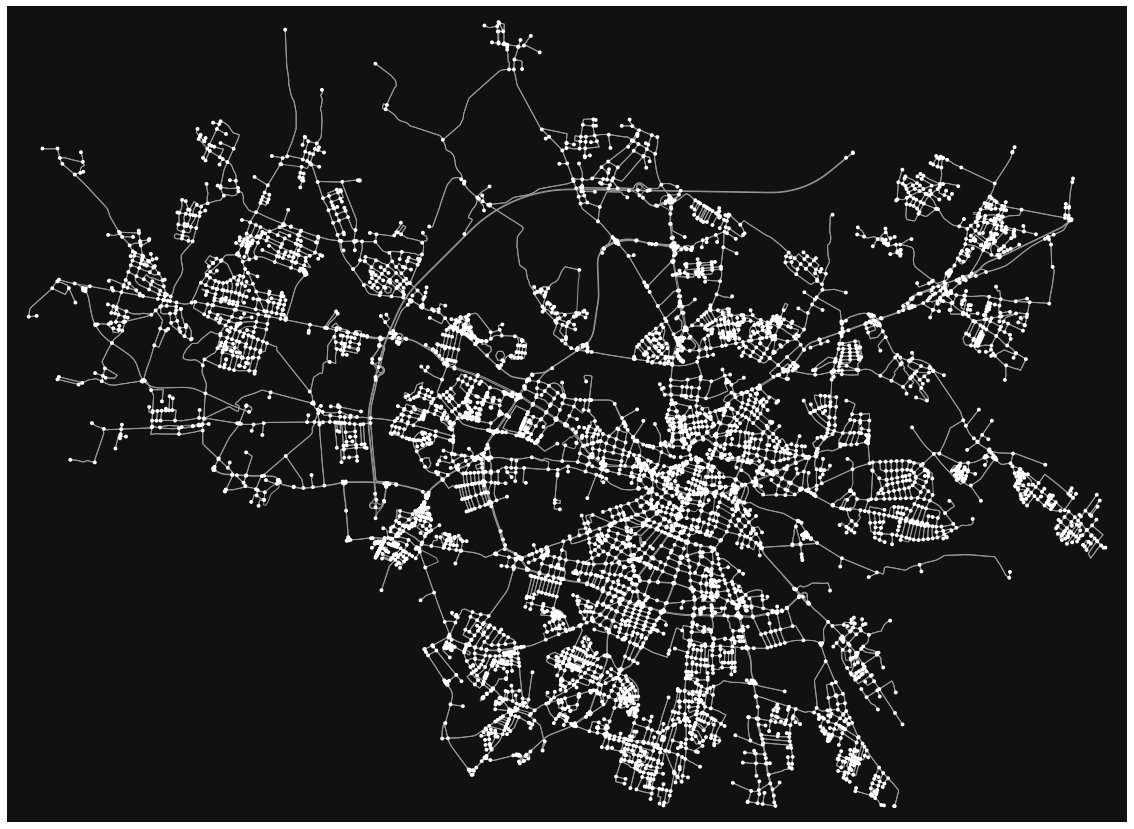

(<Figure size 2160x1080 with 1 Axes>, <AxesSubplot:>)

In [393]:
ox.plot_graph(roads_graph, figsize=(30, 15))

## **Graph of all Wrocław bus and tram routes**

<AxesSubplot:>

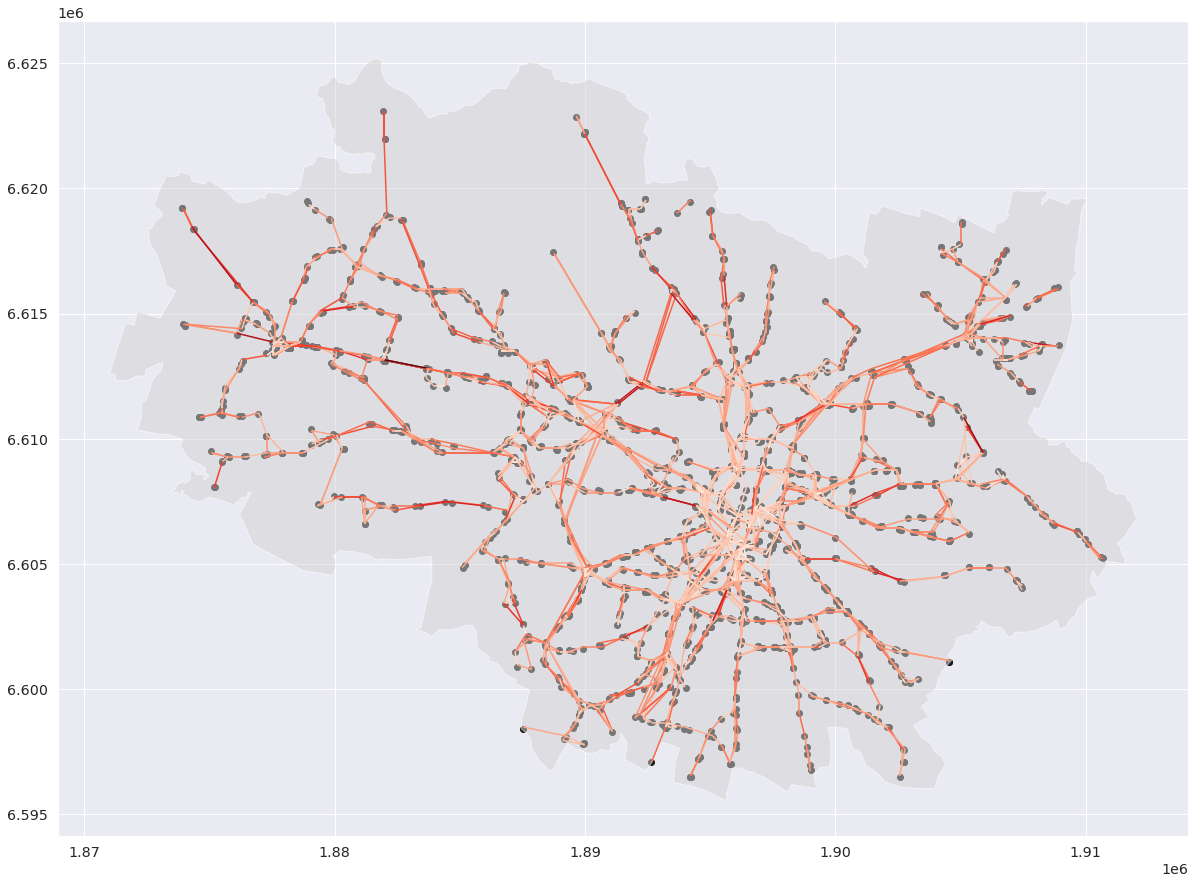

In [1036]:
fig, ax = plt.subplots(figsize=(30, 15))

cmap = plt.get_cmap("Reds")
min_max = lambda x: (x - x.min()) / (x.max() - x.min())
ec = [cmap(x) for x in min_max(stops_edges.line_velocity.values)]
# ox.plot_graph(G, ax=ax, node_color='k', edge_color=ec)

stops_edges.plot(edgecolor=ec, ax=ax)
stops_nodes.plot(ax=ax, color='k')
wroc.plot(ax=ax, color='lightgrey', alpha=0.5)

## **Stops and routes**

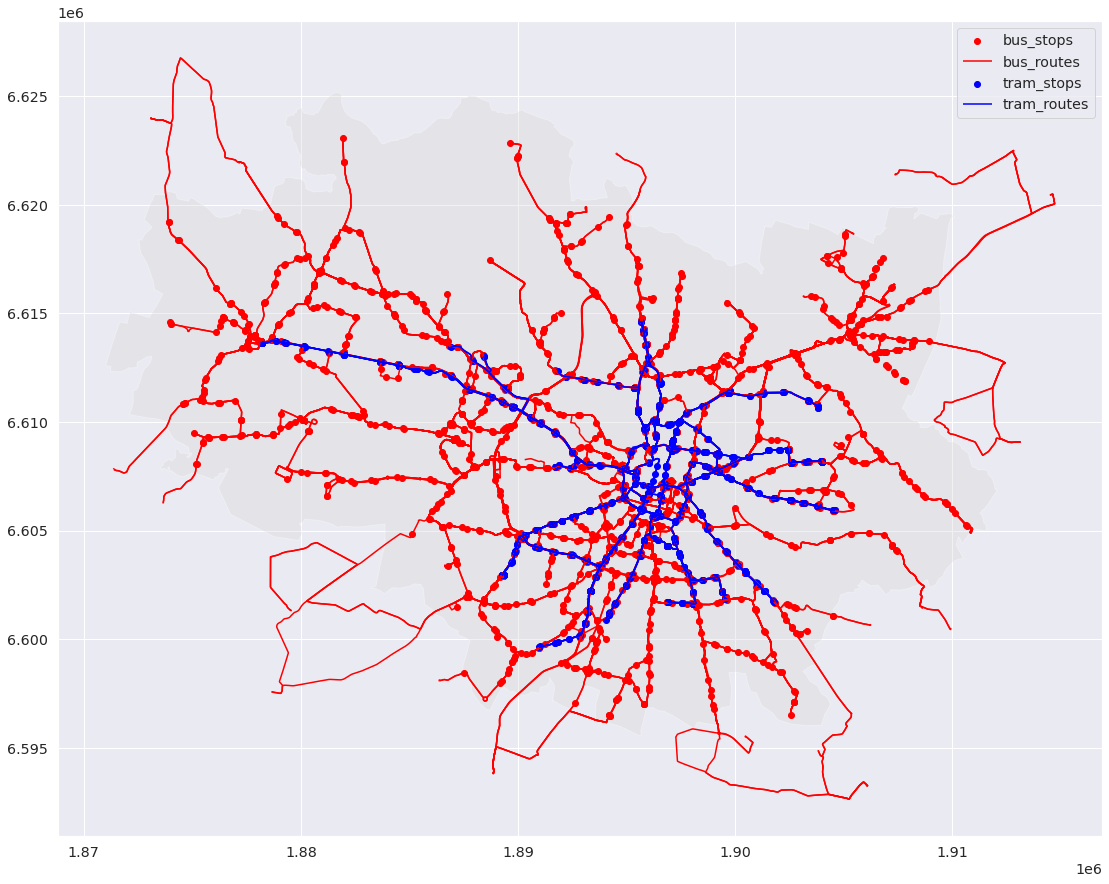

In [341]:
fig, ax = plt.subplots(figsize=(35, 15))

wroc.plot(ax=ax, color='lightgrey', alpha=0.3)

bus_stops_final.plot(color='red', ax=ax, label='bus_stops')
bus_routes_op.plot(color='red', ax=ax, label='bus_routes')

tram_stops_final.plot(color='blue', ax=ax, label='tram_stops')
tram_routes_op.plot(color='blue', ax=ax, label='tram_routes')

plt.legend()

***

## **Routes x Hour** 

> * **`y`** axes - route ids (bus/tram lines identificators)
> * **`x`** axes - hours
>
> This plot shows us the hourly dependence for each bus/tram line in Wrocław for a specifid feature (duration or velocity)

### duration

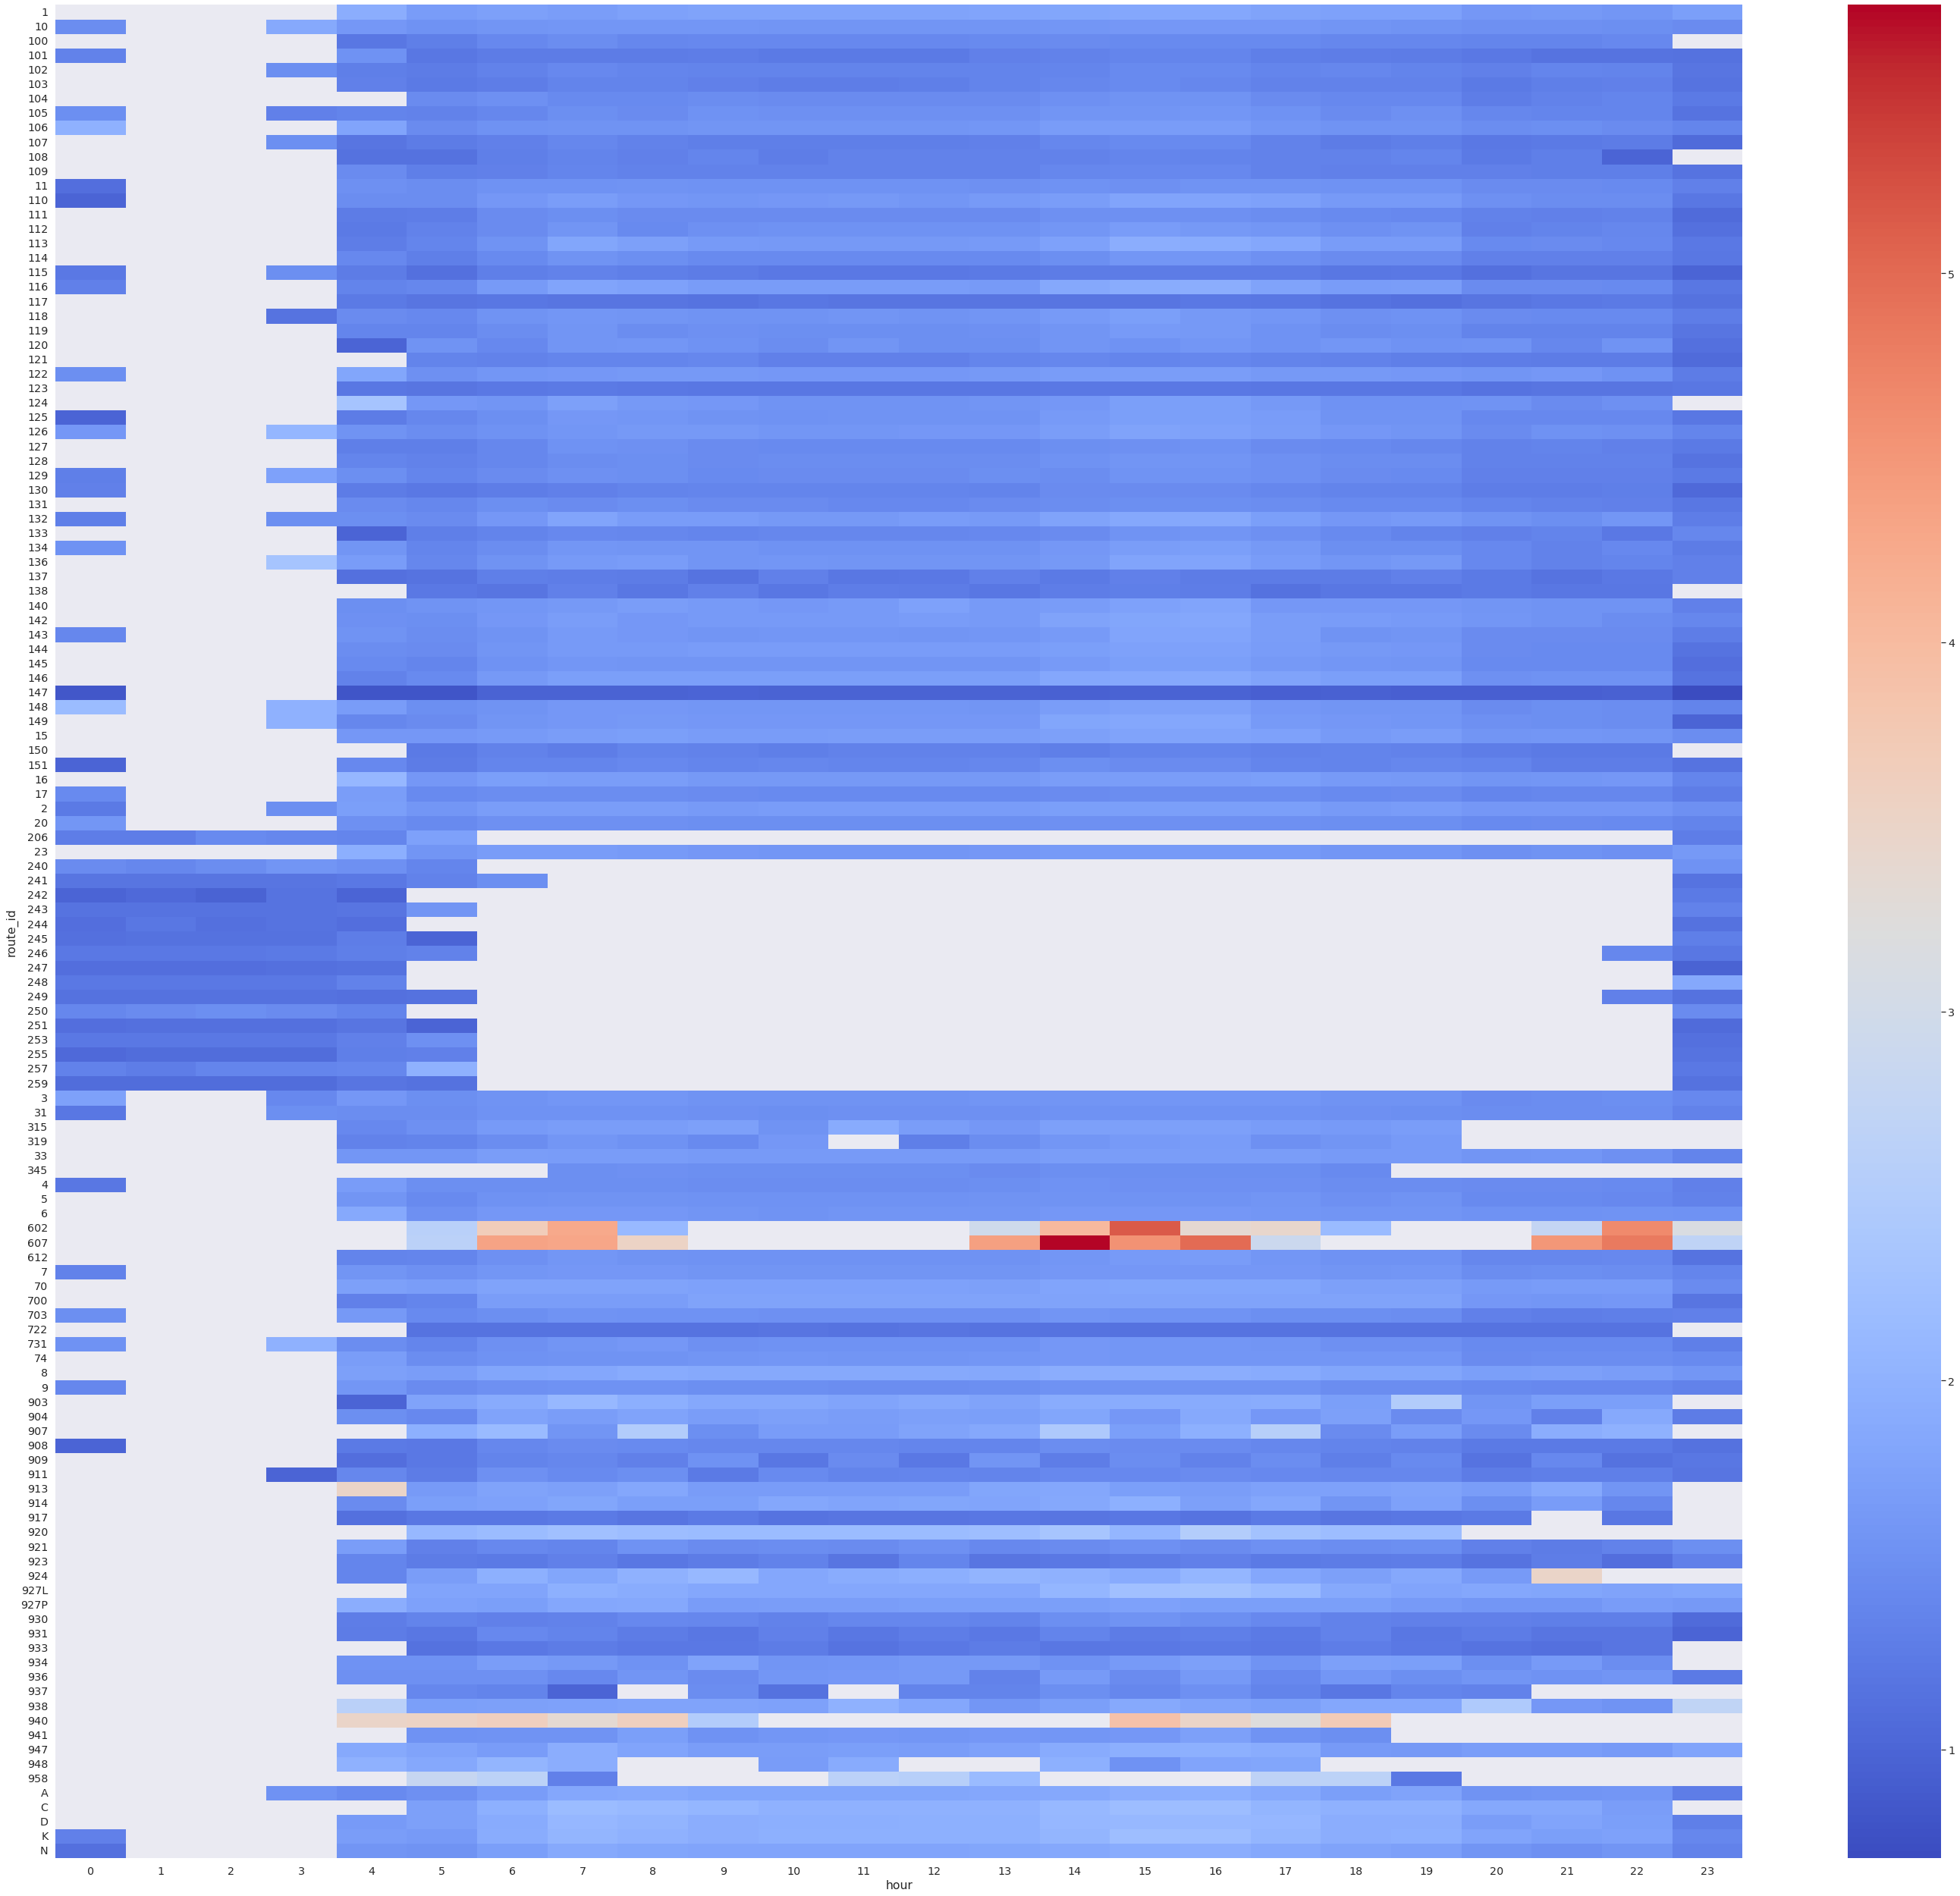

In [312]:
df = _routes_df.groupby(['route_id', 'hour']).mean().reset_index()[['route_id', 'hour', 'duration']]

pivot = df.pivot(index='route_id', columns='hour', values='duration')
plt.figure(figsize=(40, 35))
sns.heatmap(pivot, cmap='coolwarm')
plt.tight_layout()
plt.savefig("route_hour_duration.eps")

### velocity, scheduled (in line dist)

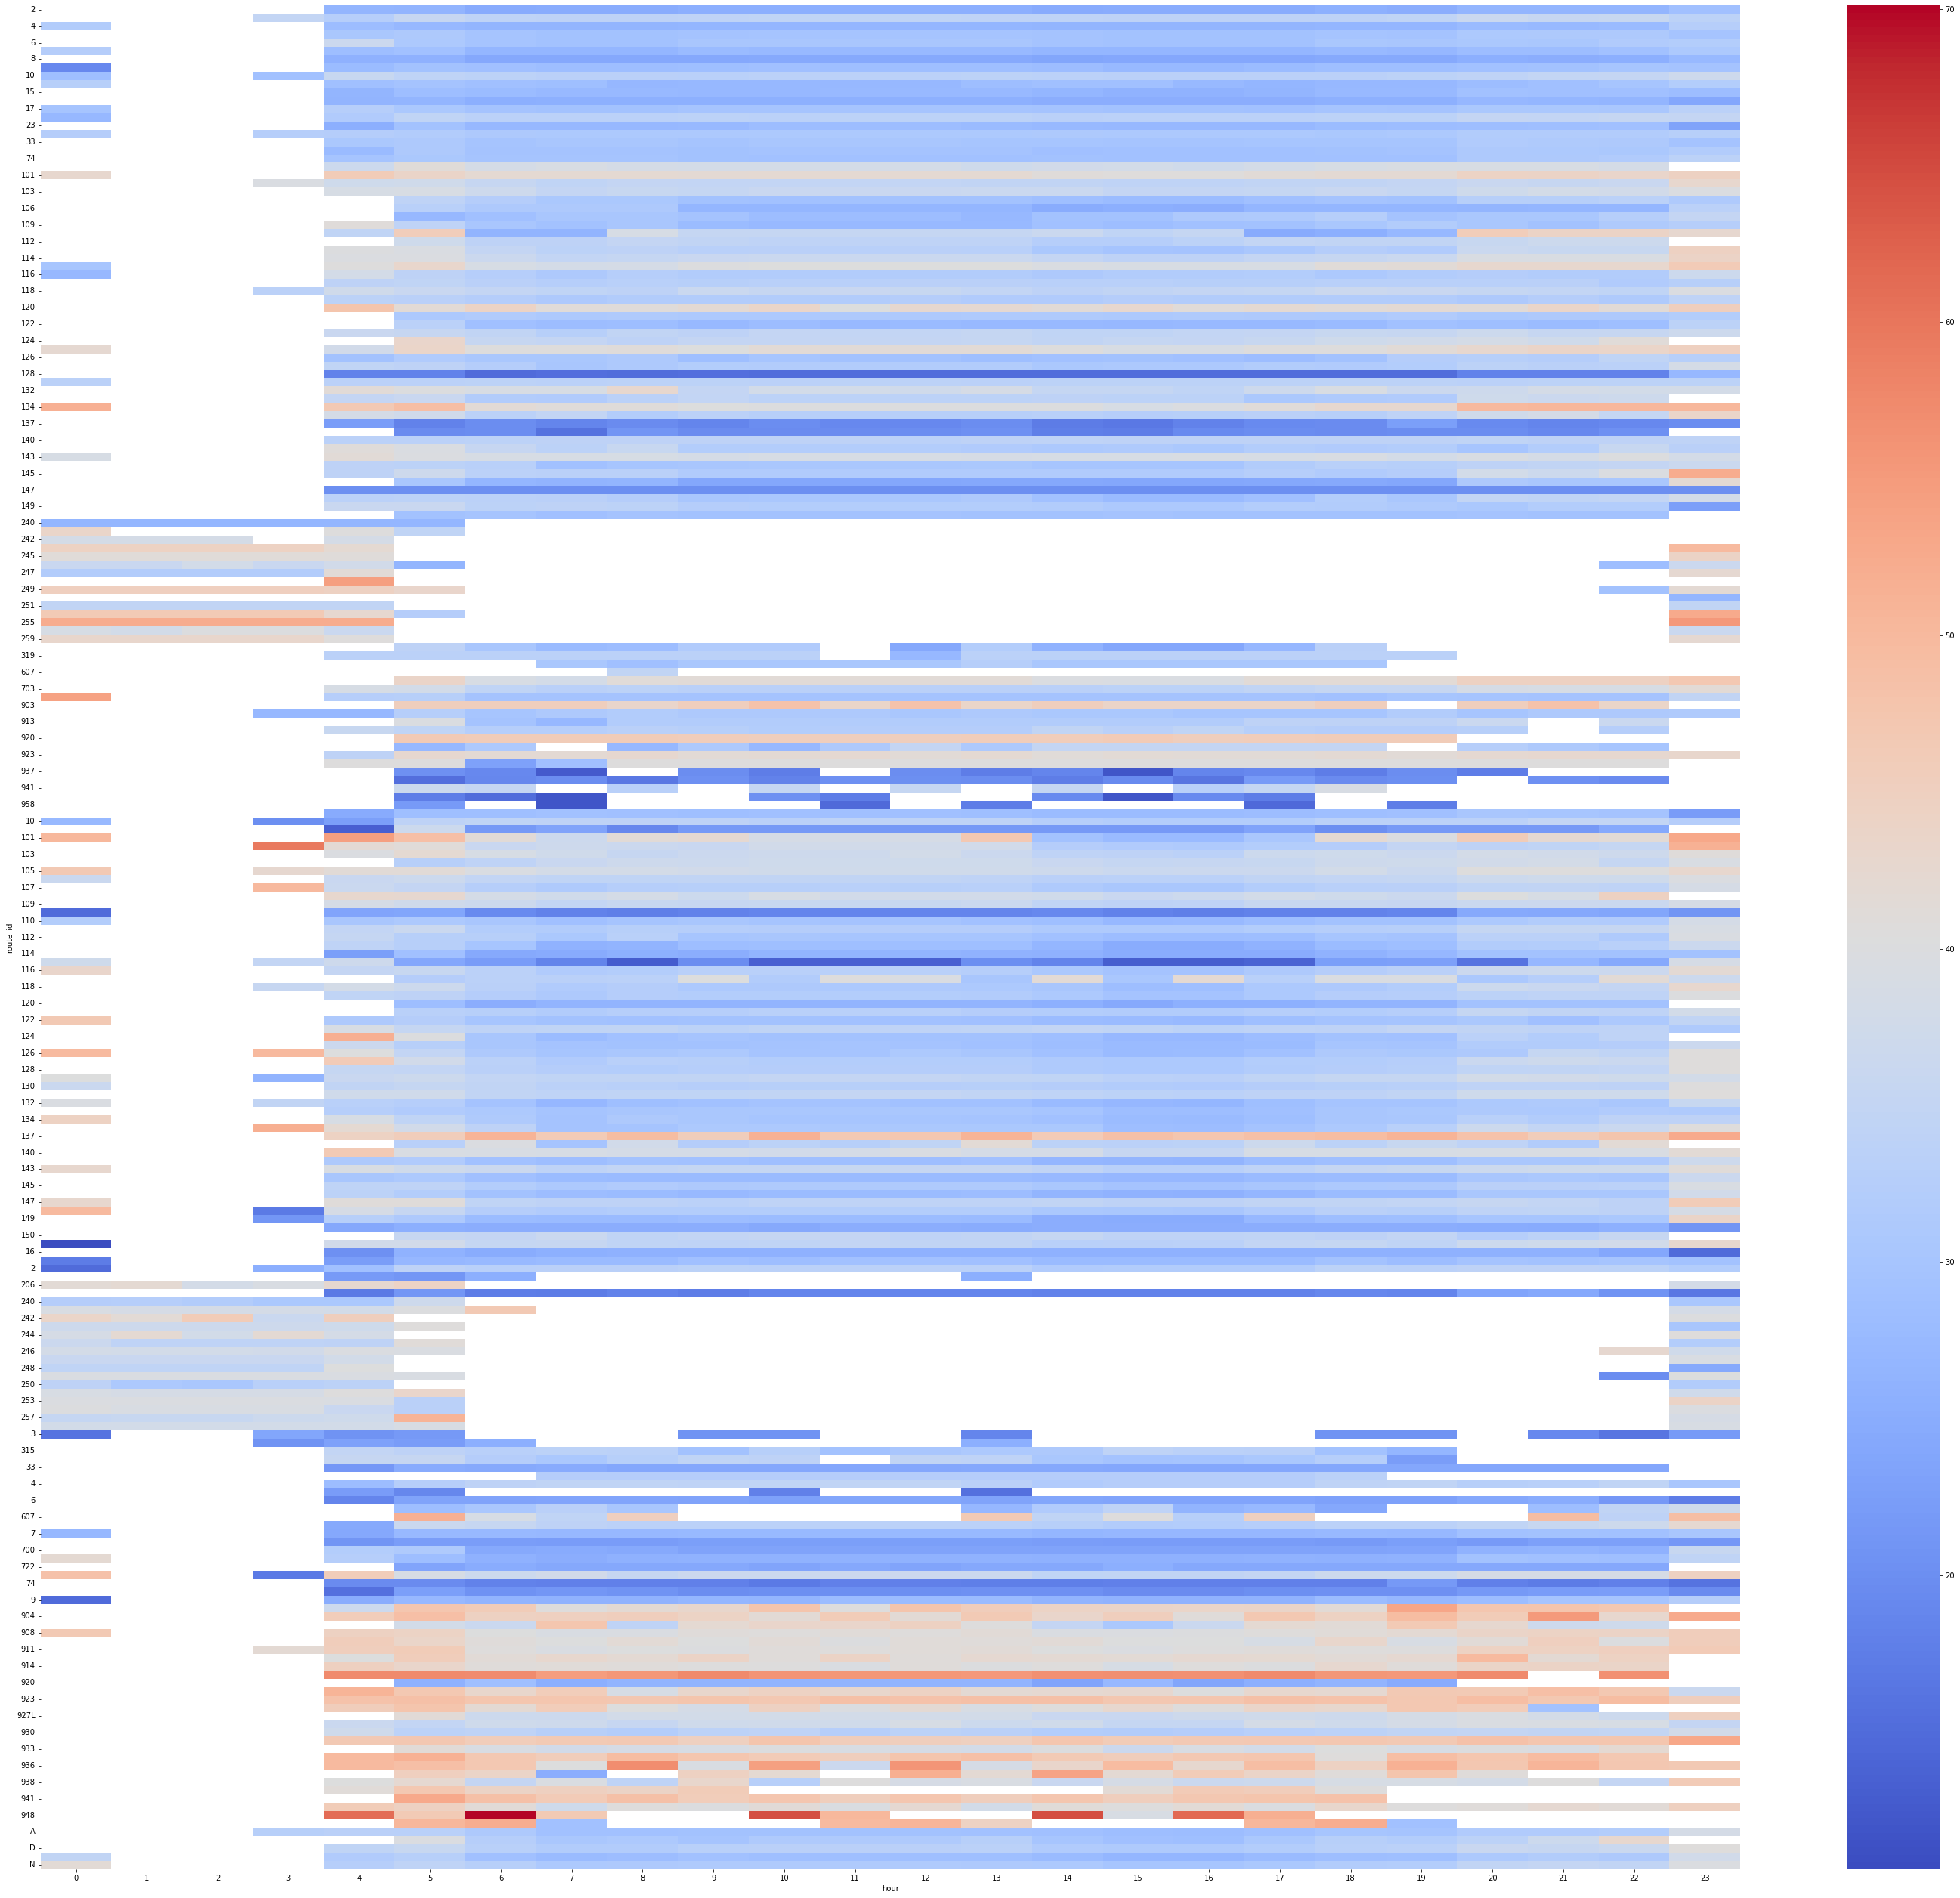

In [34]:
df = _routes_df.groupby(['route_id', 'hour']).mean().reset_index()[['route_id', 'hour', 'line_velocity']]

pivot = df.pivot(index='route_id', columns='hour', values='line_velocity')
plt.figure(figsize=(40, 35))
sns.heatmap(pivot, cmap='coolwarm')
plt.tight_layout()
plt.savefig("route_hour_line_velocity.eps")

### velocity, scheduled (in real dist)

### velocity, real world data (in real dist)

***

## **mean Houry** 

> Comparison of Scheduled and real features aggregated by hours

### duration (scheduled data)

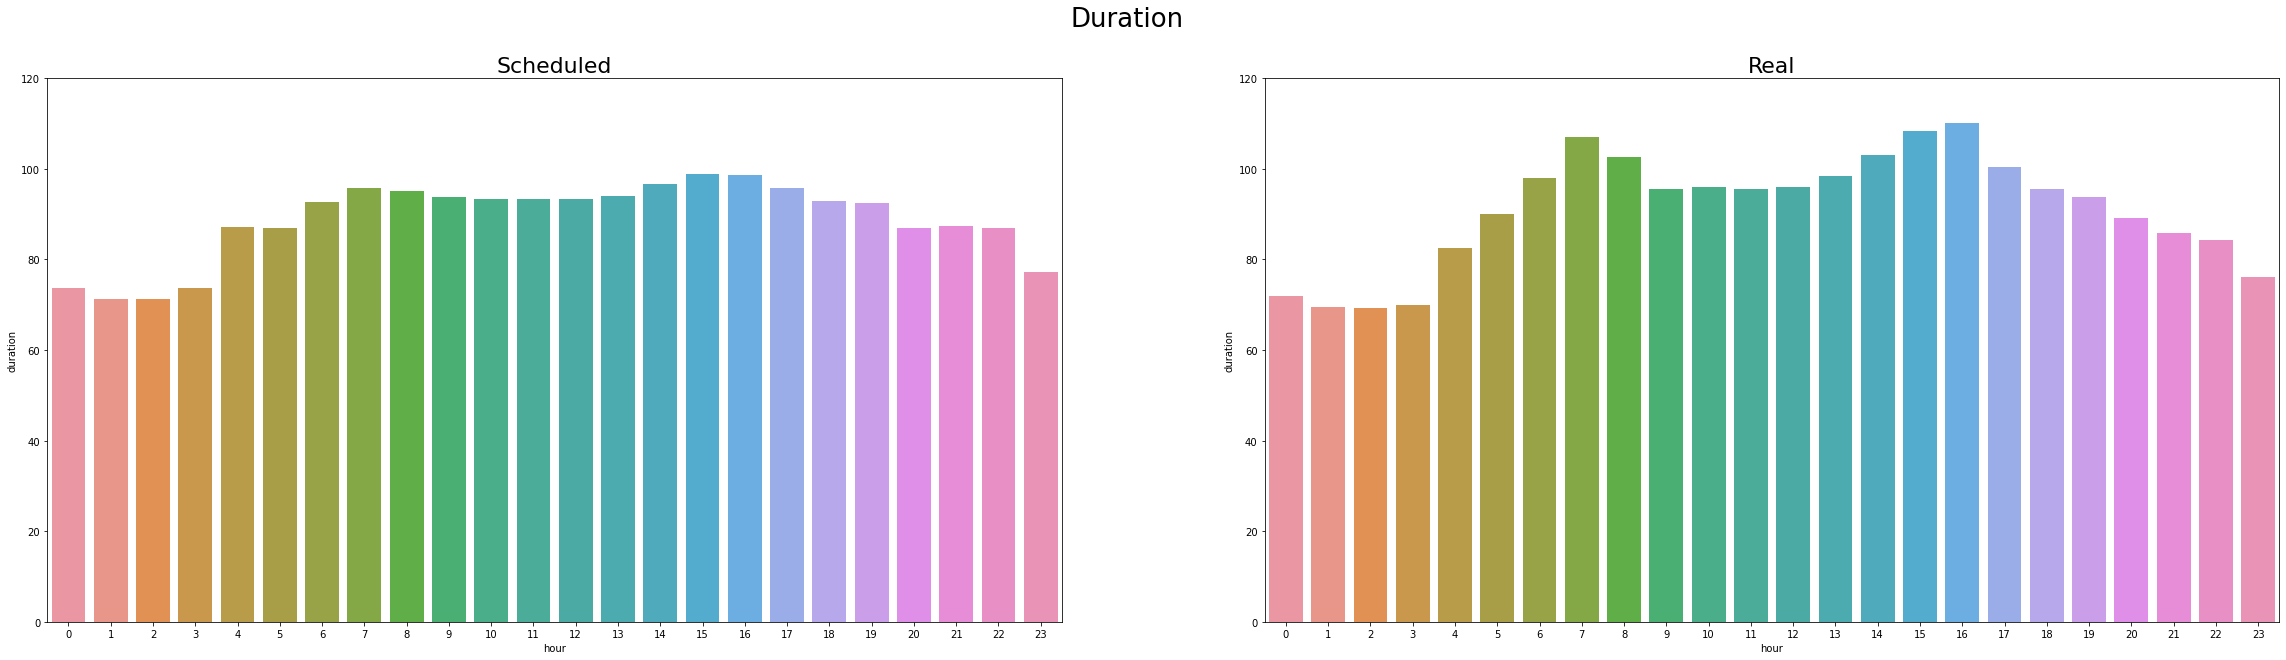

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(40, 10))
sns.barplot(
    data=_routes_df.set_index(['source-target', 'hour']).groupby('hour').mean().reset_index()[['hour', 'duration']], 
    x='hour', y='duration', ax=axes[0]
)
sns.barplot(
    data=_recorded_trips.set_index(['source-target', 'hour']).groupby('hour').mean().reset_index()[['hour', 'duration']], 
    x='hour', y='duration', ax=axes[1]
)
axes[0].set_title("Scheduled", fontsize=22)
axes[1].set_title("Real", fontsize=22)

for ax in axes:
    ax.set_ylim([0, 120])
    
fig.suptitle("Duration", fontsize=26)
plt.savefig("mean_hour_duration.eps")

### velocity (in line dist)

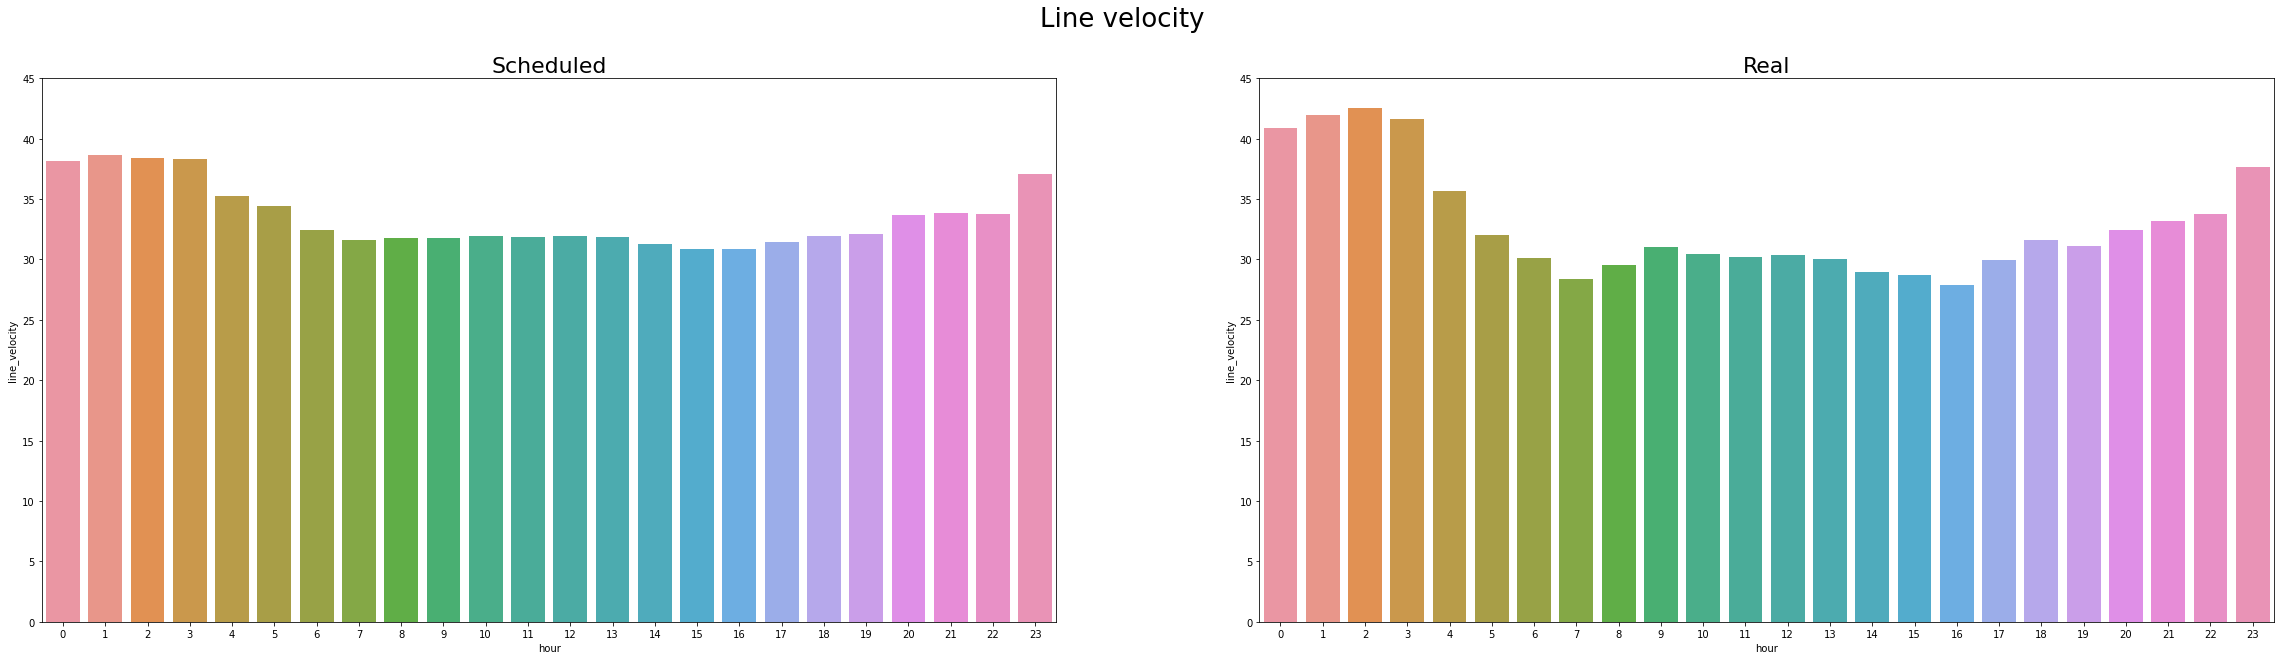

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(40, 10))

sns.barplot(
    data=_routes_df.set_index(['source-target', 'hour']).groupby('hour').mean().reset_index()[['hour', 'line_velocity']], 
    x='hour', y='line_velocity', ax=axes[0]
)
sns.barplot(
    data=_recorded_trips.set_index(['source-target', 'hour']).groupby('hour').mean().reset_index()[['hour', 'line_velocity']], 
    x='hour', y='line_velocity', ax=axes[1]
)
axes[0].set_title("Scheduled", fontsize=22)
axes[1].set_title("Real", fontsize=22)

for ax in axes:
    ax.set_ylim([0, 45])

fig.suptitle("Line velocity", fontsize=26)
plt.savefig("mean_hour_line_velocity.eps")

### velocity (in real dist)

***

## **Put on map** 

> The analysed features put on map as hexbins (aggregation of values for specific region on map)
> The analysis is made for specific hour ranges:
> * 00 - 01
> * 04 - 05
> * 08 - 09
> * 12 - 12
> * 16 - 17
> * 20 - 21

In [26]:
hours = [0, 4, 8, 12, 16, 20]

In [123]:
def plot_hexbin(city_gdf, routes_df, hour, value_name, fig=None, ax=None, title=None, min_cvalue=None, max_cvalue=None):
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=(18, 10))
    x, y = [], []
    for point in routes_df.geometry.values:
        if str(type(point)) != "<class 'NoneType'>":
            x.append(point.coords.xy[0][0])
            y.append(point.coords.xy[1][0])
    values = routes_df[value_name].values
    city_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
    hexplot = ax.hexbin(x, y, values, cmap='Reds', gridsize=30)
    cbar = fig.colorbar(hexplot, ax=ax)
    cbar.set_label(value_name)
    # if min_cvalue is not None and max_cvalue is not None:
    #     cbar.mappable.set_clim(min_cvalue, max_cvalue)
    if title is not None:
        ax.set_title(f"{title} | {value_name} (hours: {str(hour).zfill(2)} - {str((hour+1)%24).zfill(2)})", fontsize=22)
    else:
        ax.set_title(f"{value_name} (hours: {str(hour).zfill(2)} - {str((hour+1)%24).zfill(2)})", fontsize=22)
        
    ax.set_xlabel("X coord", fontsize=18)
    ax.set_ylabel("Y coord", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
def plot_hexbin_for_hours(city_gdf, routes_df, value_name, hours, title=''):
    ncols = 3 if len(hours) >=3 else len(hours)
    nrows = math.ceil(len(hours) / ncols)
    xlims = []
    ylims = []
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*13, nrows*10))
    
    for i, hour in enumerate(hours):
        ax = axes[i // ncols, i % ncols] if nrows > 1 else axes[i]
        hour_routes = routes_df[routes_df['hour'] == hour]
        min_cvalue = hour_routes[value_name].min()
        max_cvalue = hour_routes[value_name].max()
        
        plot_hexbin(
            city_gdf, hour_routes, hour=hour, value_name=value_name, fig=fig, ax=ax, min_cvalue=min_cvalue, max_cvalue=max_cvalue
        )
        xlims.extend(list(ax.get_xlim()))
        ylims.extend(list(ax.get_ylim()))

    for ax in axes.flatten():
        ax.set_xlim(min(xlims), max(xlims))
        ax.set_ylim(min(ylims), max(ylims))
    
    fig.suptitle(title, fontsize=26)
    plt.tight_layout()
    plt.savefig(f"plots/mapped_{title}_{value_name}.eps" if title is not None else f"mapped_{value_name}.eps")
    
def compare_real_and_scheduled_hexbin_for_hours(city_gdf, real_df, scheduled_df, value_name, hours):
    xlims = []
    ylims = []
    fig, axes = plt.subplots(len(hours), 2, figsize=(40, len(hours)*10))
    
    for i, hour in enumerate(hours):
        ax1, ax2 = axes[i, 0], axes[i, 1]
        hour_scheduled = scheduled_df[scheduled_df['hour'] == hour]
        hour_real = real_df[real_df['hour'] == hour]
        same_source_stops = list(set(hour_scheduled['source_stop_id'].values).intersection(set(hour_real['source_stop_id'].values)))
        good_scheduled_stops = [stop in same_source_stops for stop in hour_scheduled['source_stop_id'].values]
        good_real_stops = [stop in same_source_stops for stop in hour_real['source_stop_id'].values]
        
        hour_scheduled = hour_scheduled[good_scheduled_stops]
        hour_real = hour_real[good_real_stops]
        
        

        min_cvalue = min([hour_real[value_name].min(), hour_scheduled[value_name].min()])
        max_cvalue = max([hour_real[value_name].max(), hour_scheduled[value_name].max()])
        
        plot_hexbin(city_gdf, hour_scheduled, hour=hour, value_name=value_name, fig=fig, ax=ax1, title="Scheduled", min_cvalue=min_cvalue, max_cvalue=max_cvalue)
        plot_hexbin(city_gdf, hour_real, hour=hour, value_name=value_name, fig=fig, ax=ax2, title="Real", min_cvalue=min_cvalue, max_cvalue=max_cvalue)
        
        xlims.extend(list(ax1.get_xlim()) + list(ax2.get_xlim()))
        ylims.extend(list(ax1.get_ylim()) + list(ax2.get_ylim()))

    for ax in axes.flatten():
        ax.set_xlim(min(xlims), max(xlims))
        ax.set_ylim(min(ylims), max(ylims))

    plt.tight_layout()
    plt.savefig(f"plots/mapped_{value_name}_comparison.eps")

### **duration**

#### Scheduled

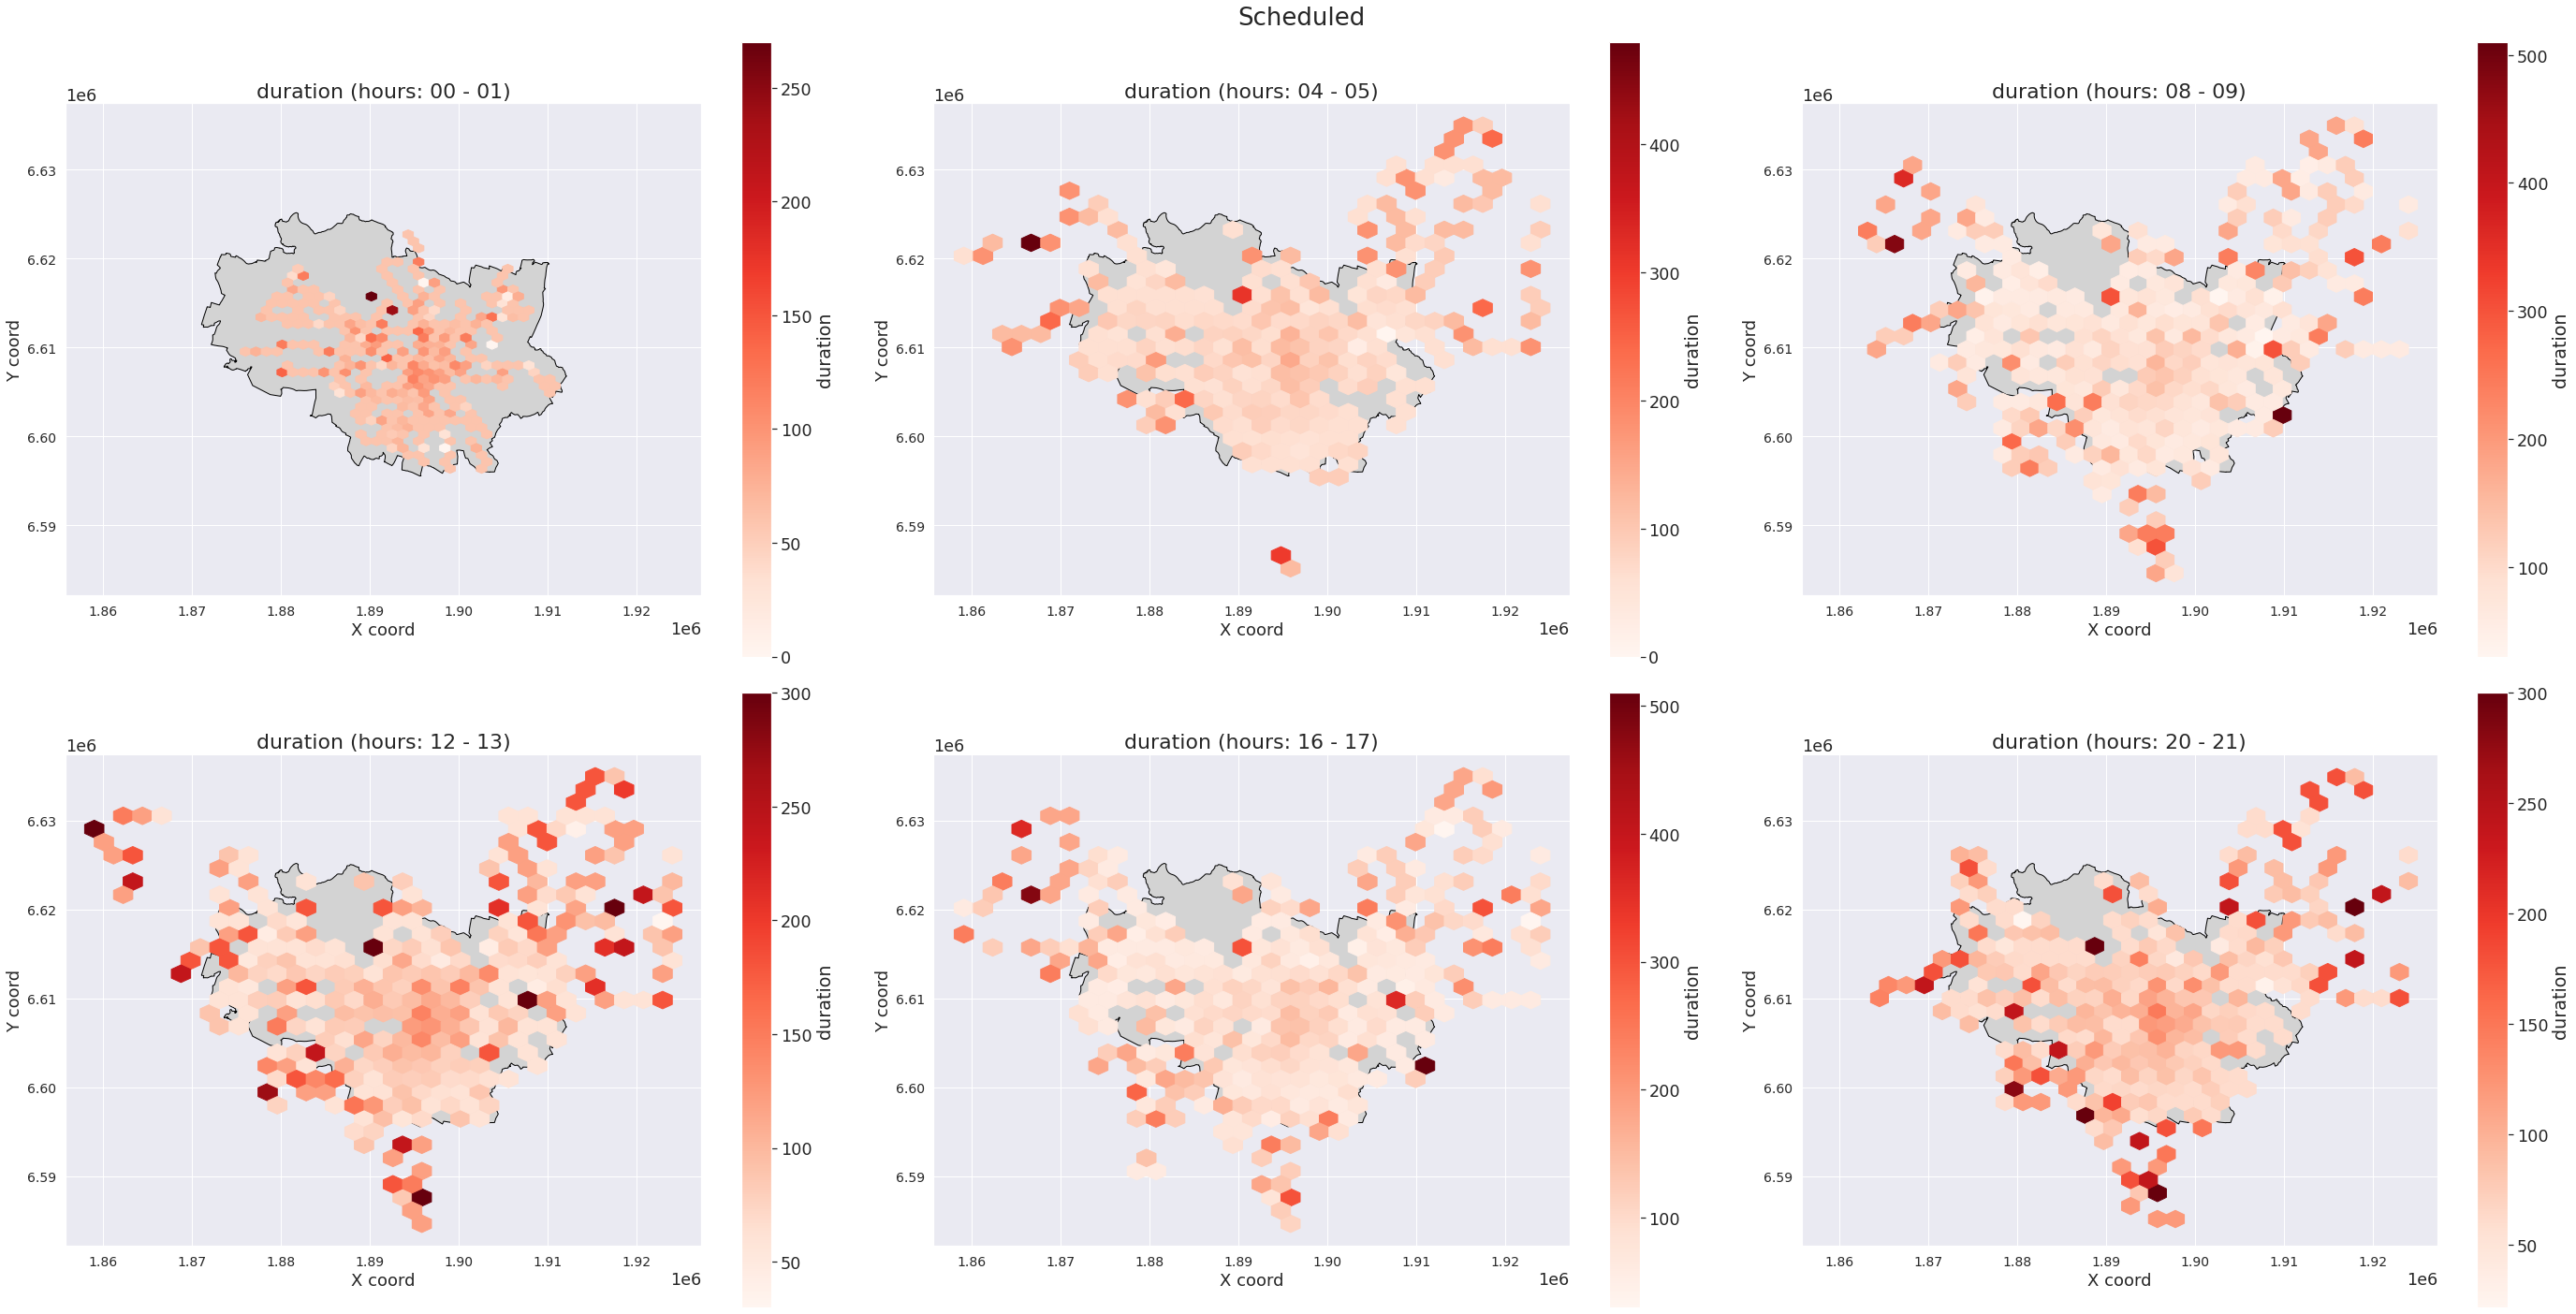

In [302]:
plot_hexbin_for_hours(wroc, _routes_df, value_name='duration', hours=hours, title="Scheduled")

#### Real

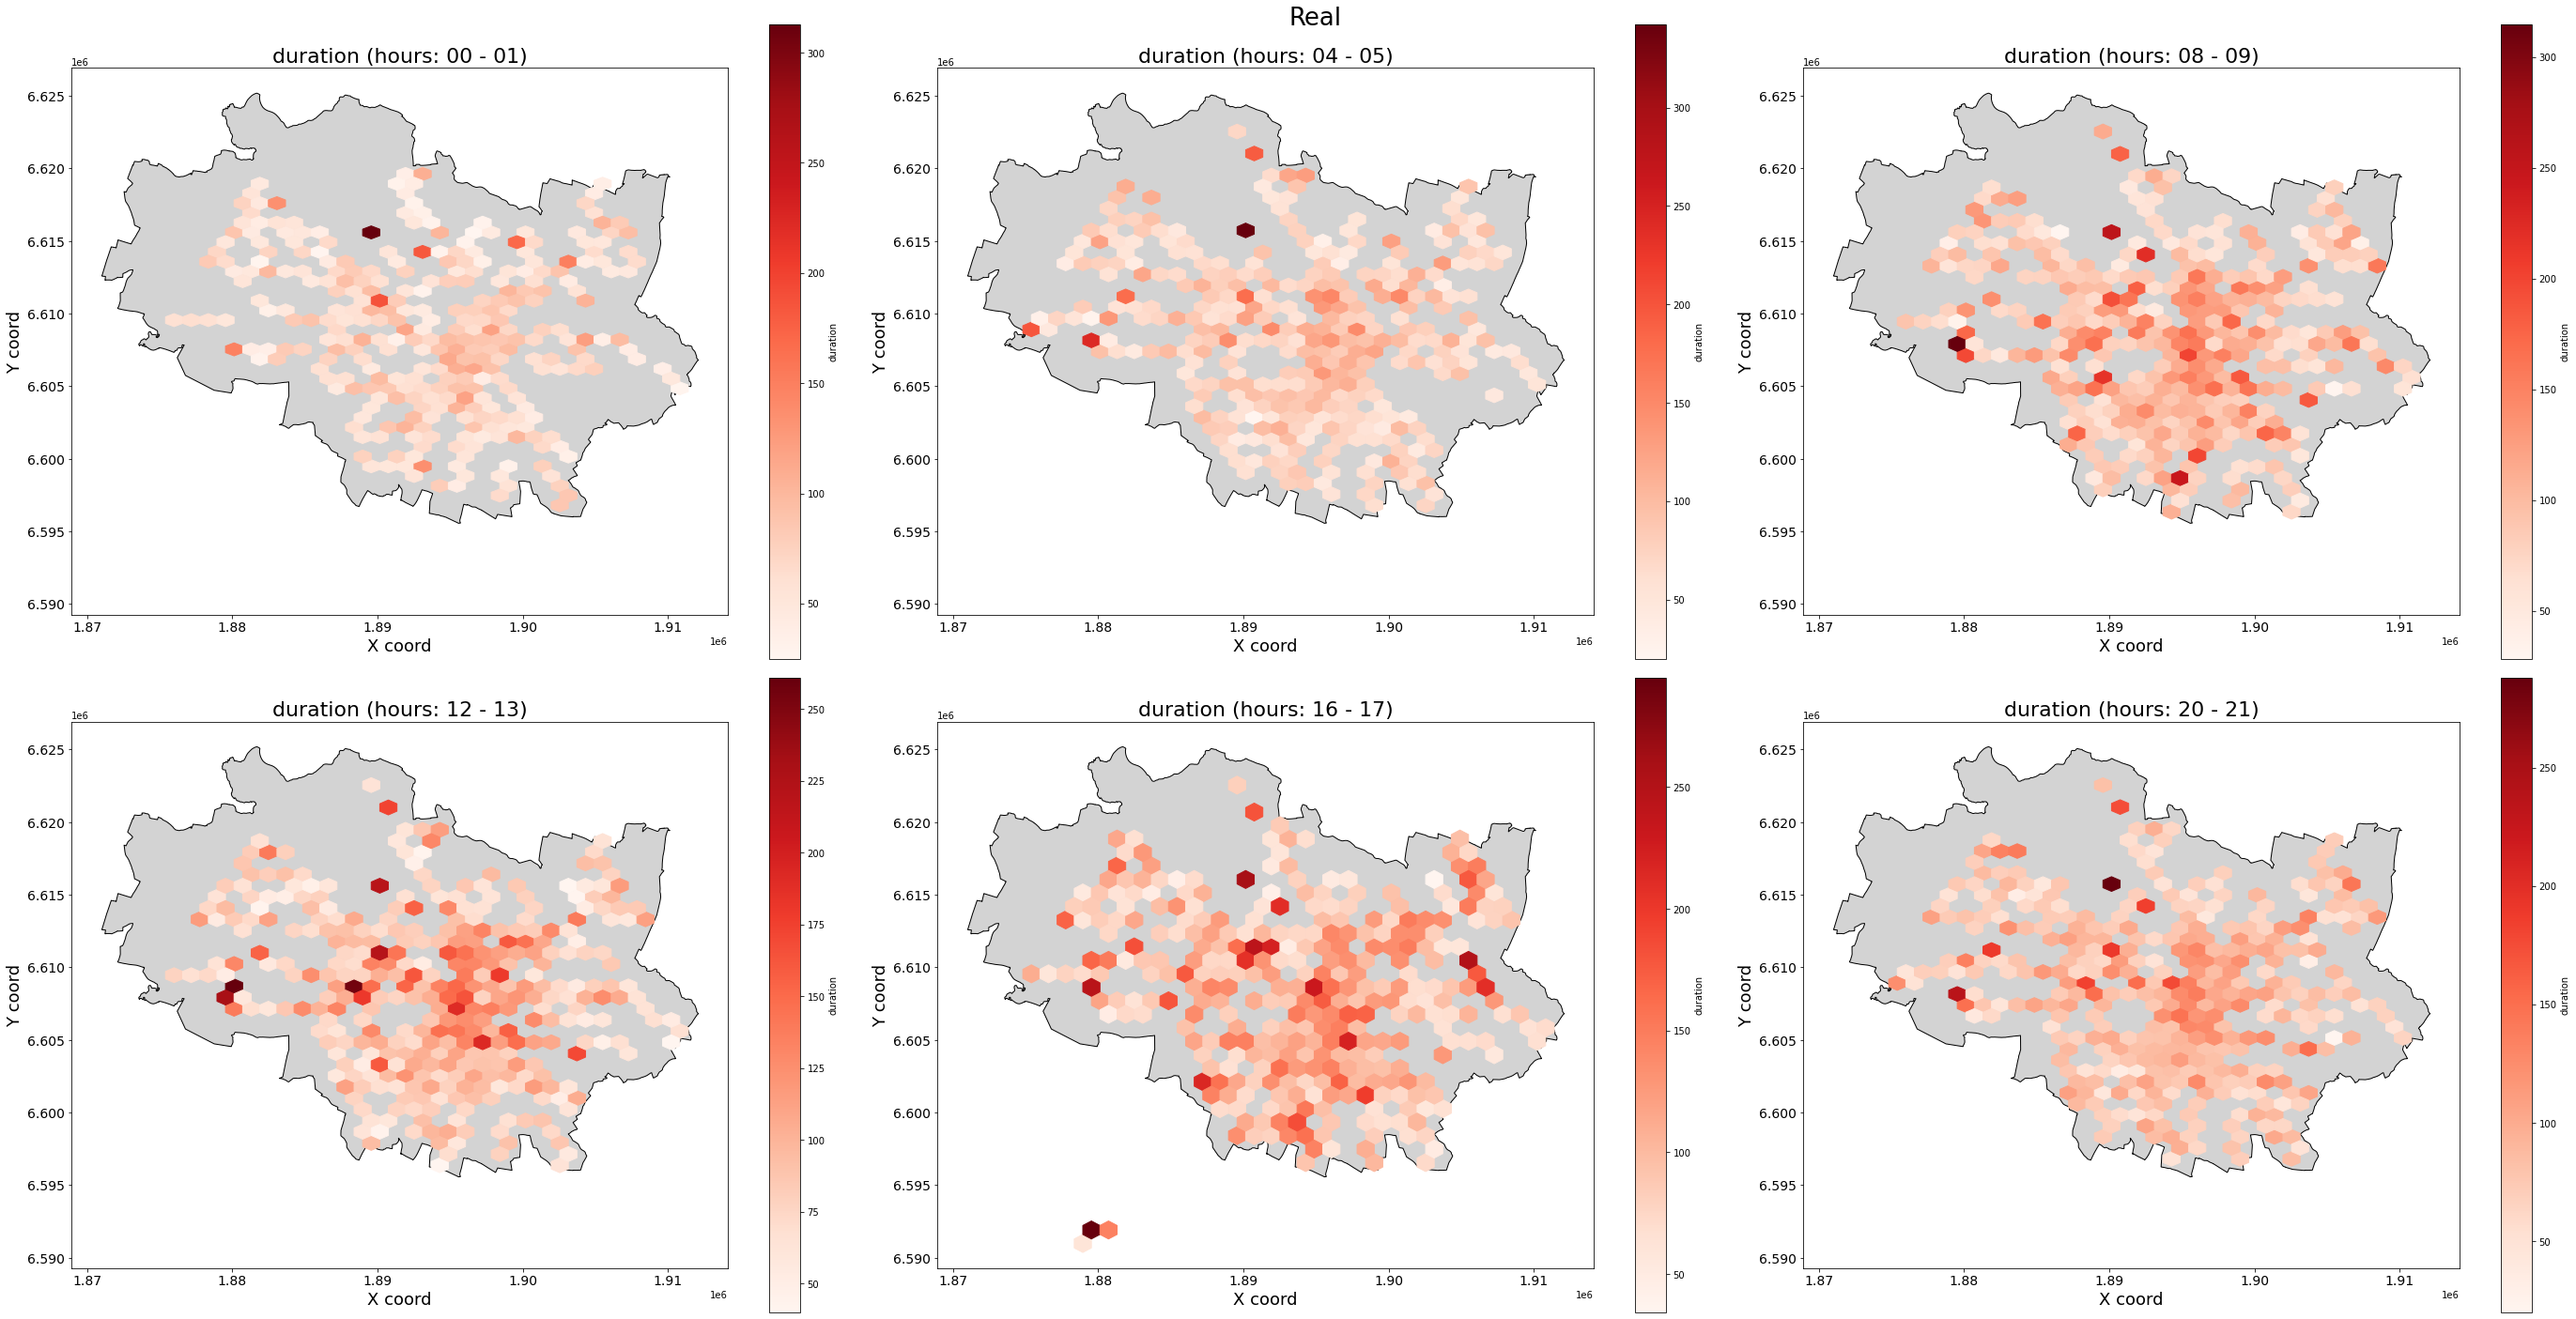

In [28]:
plot_hexbin_for_hours(wroc, _recorded_trips, value_name='duration', hours=hours, title="Real")

#### Comparison

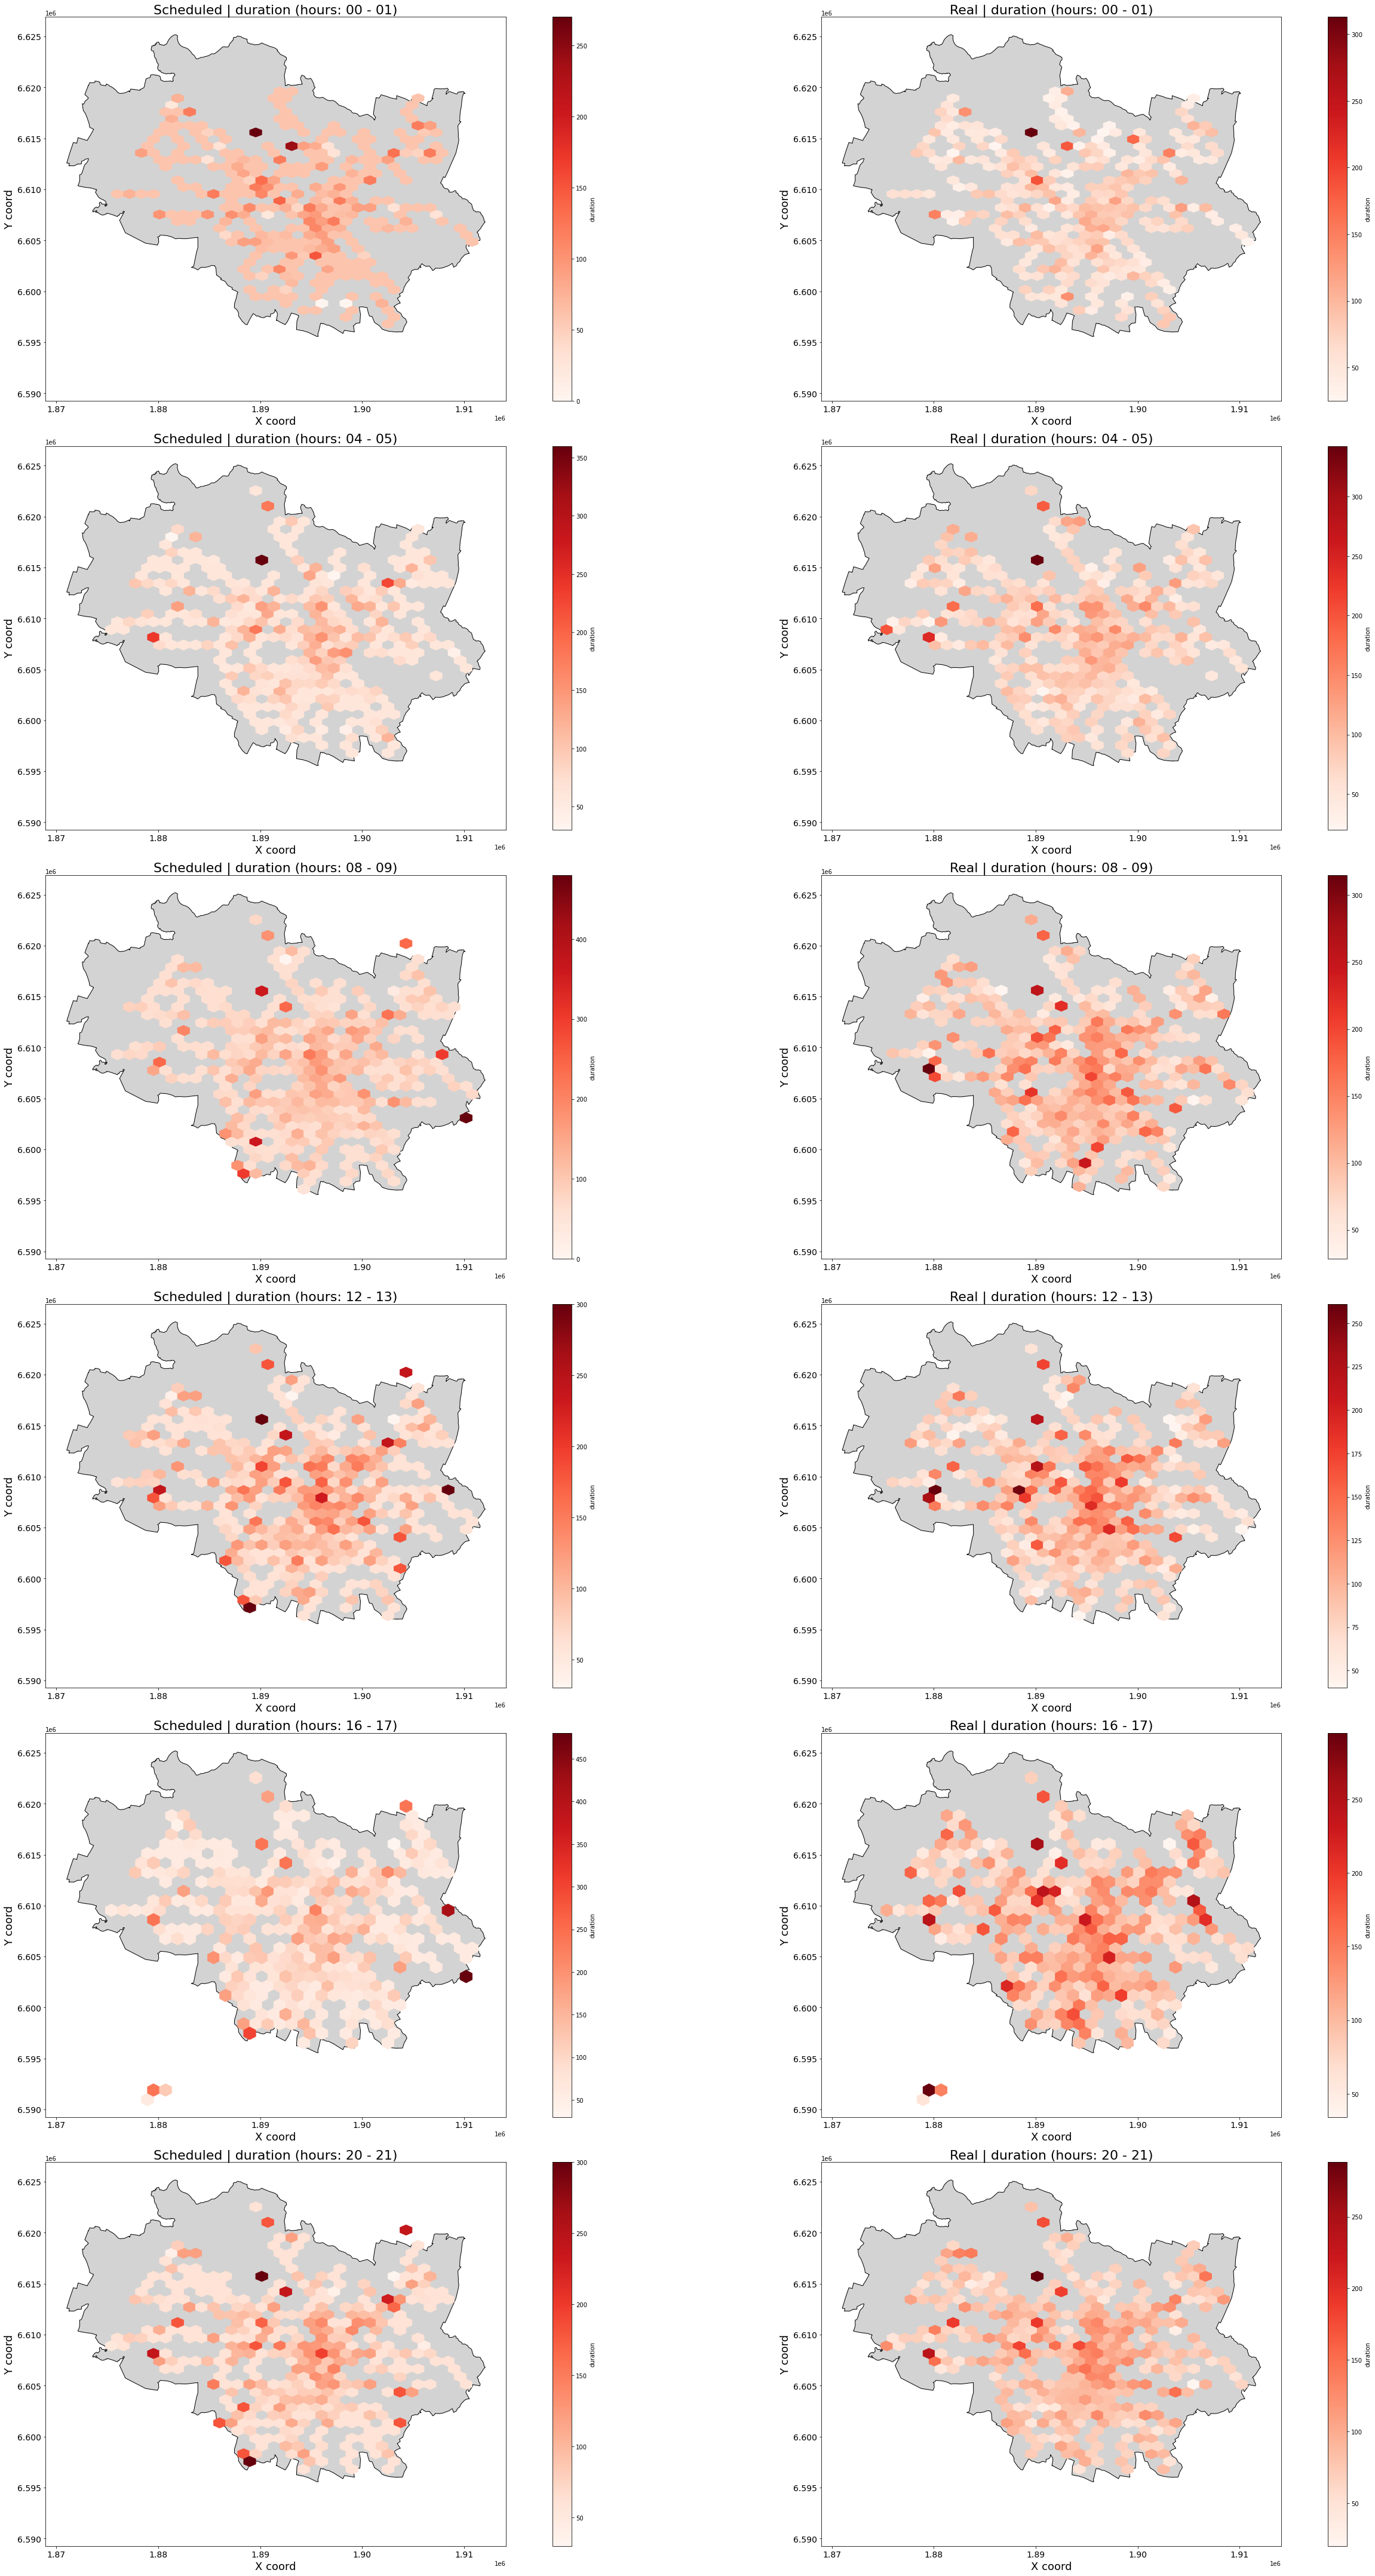

In [29]:
compare_real_and_scheduled_hexbin_for_hours(
    city_gdf=wroc, 
    real_df=_recorded_trips, 
    scheduled_df=_routes_df, 
    value_name='duration', 
    hours=hours
)

---
### **velocity (in line dist)**

#### Scheduled

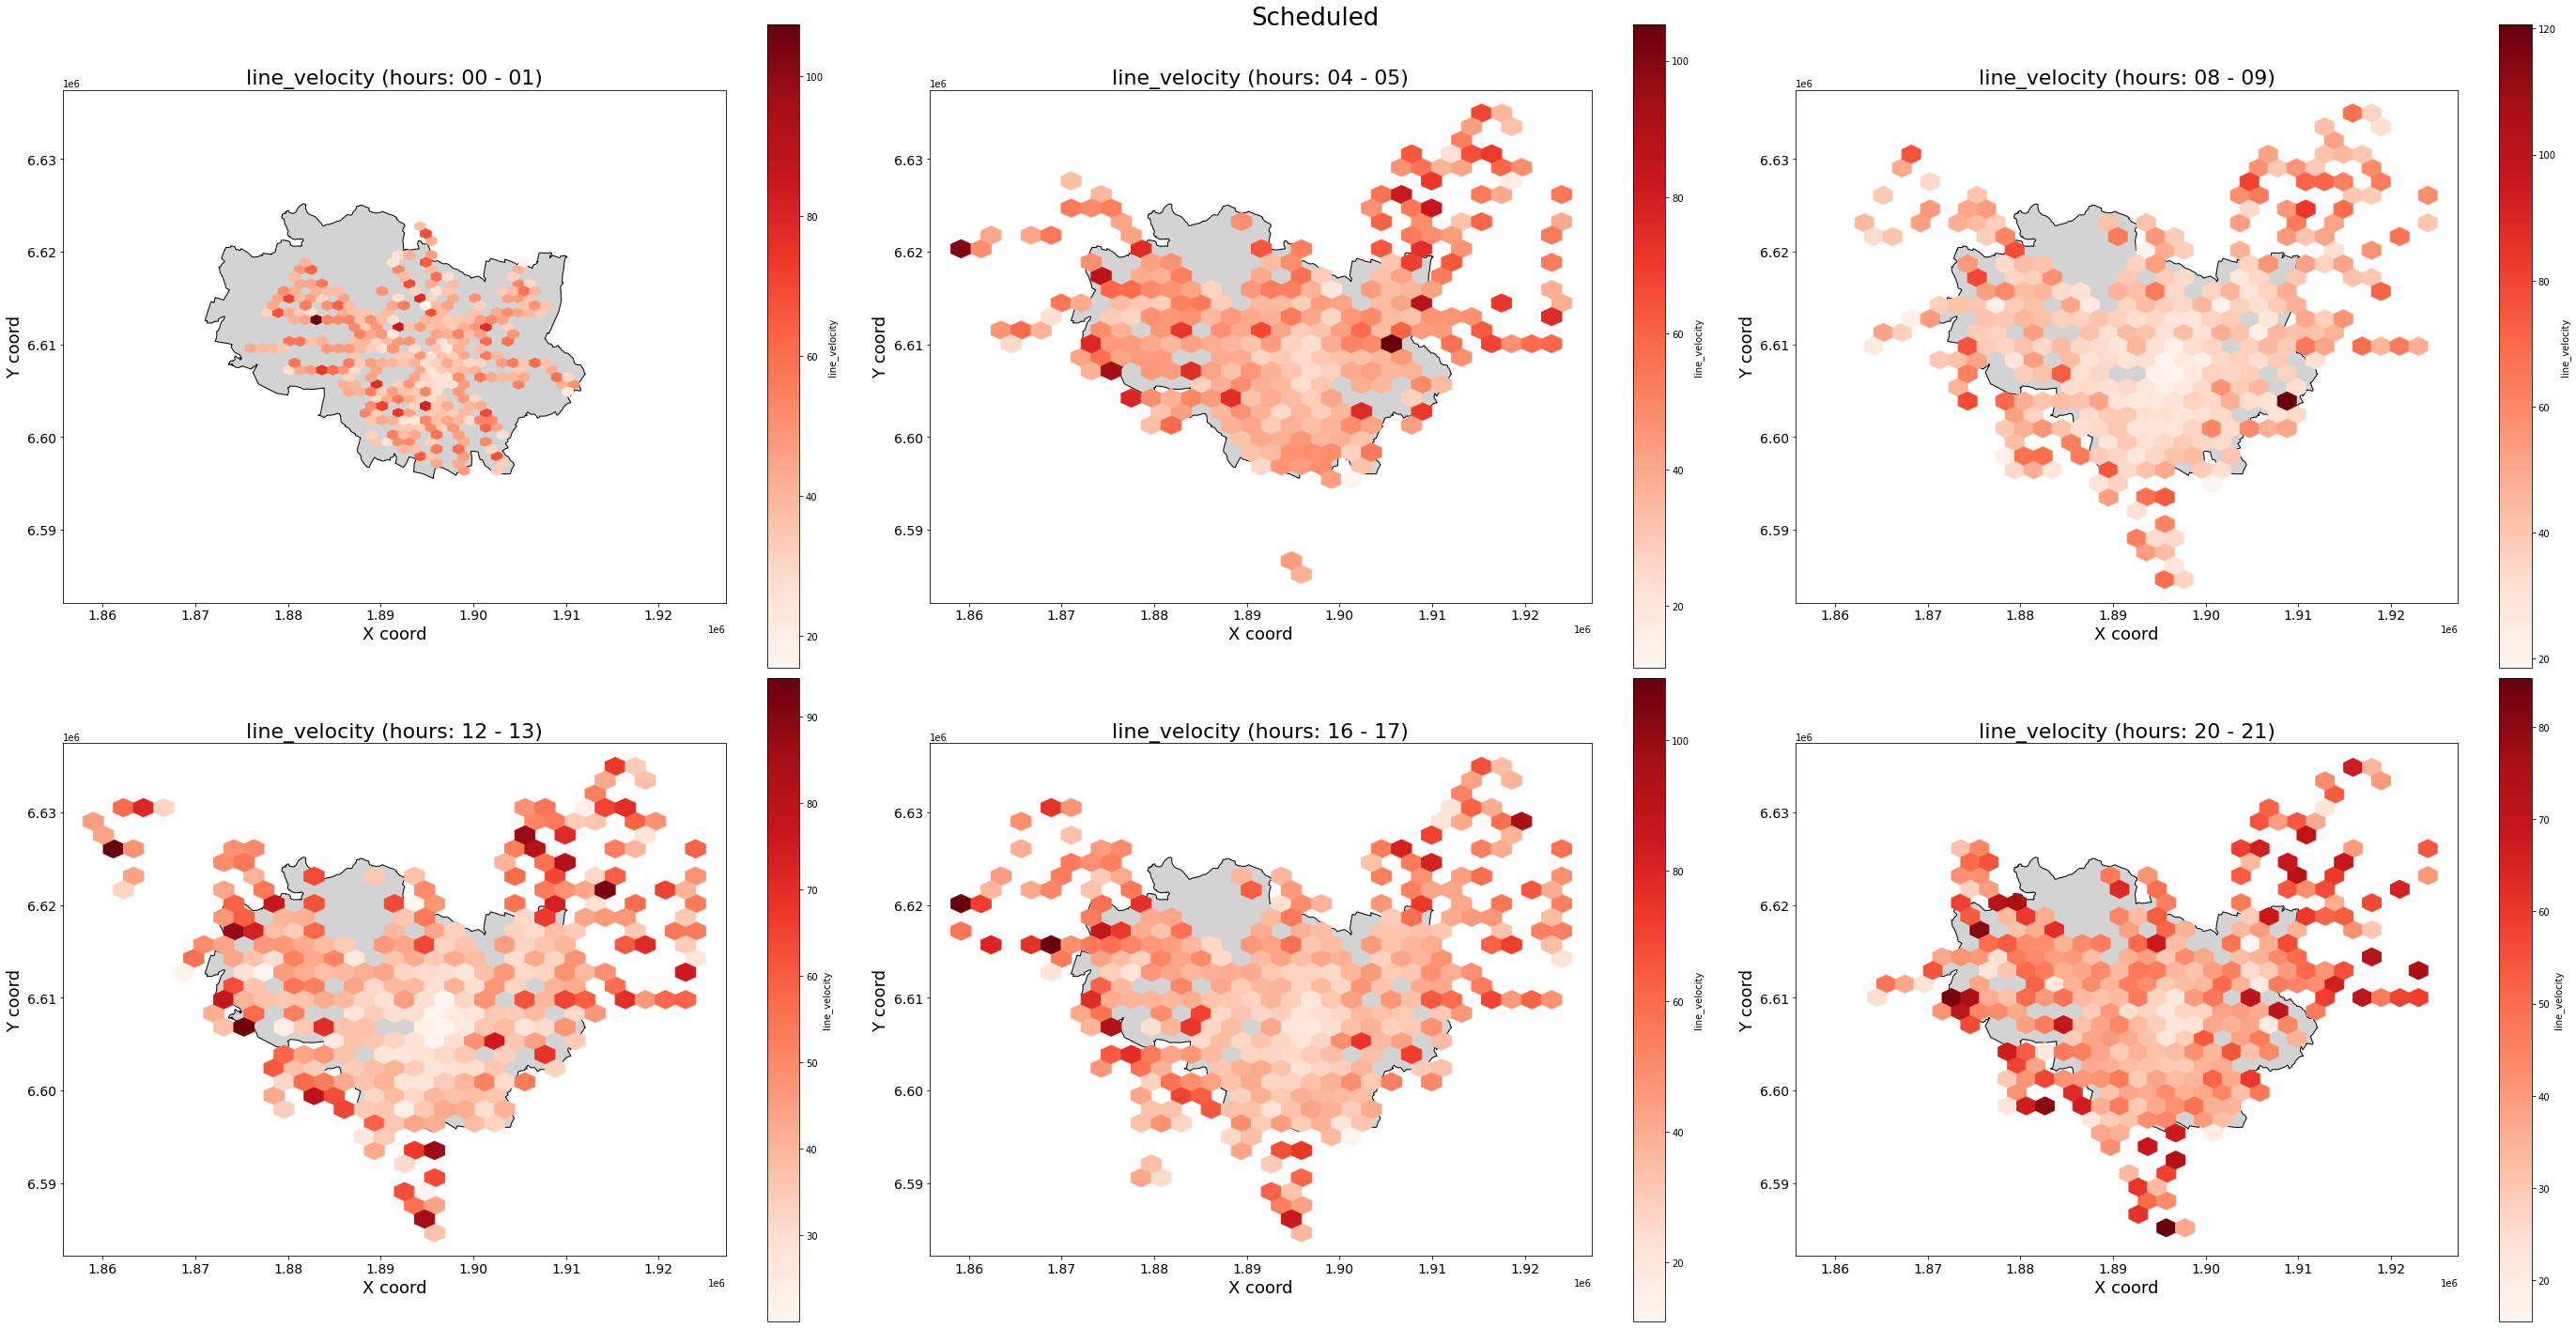

In [124]:
plot_hexbin_for_hours(wroc, _routes_df, value_name='line_velocity', hours=hours, title="Scheduled")

#### Real

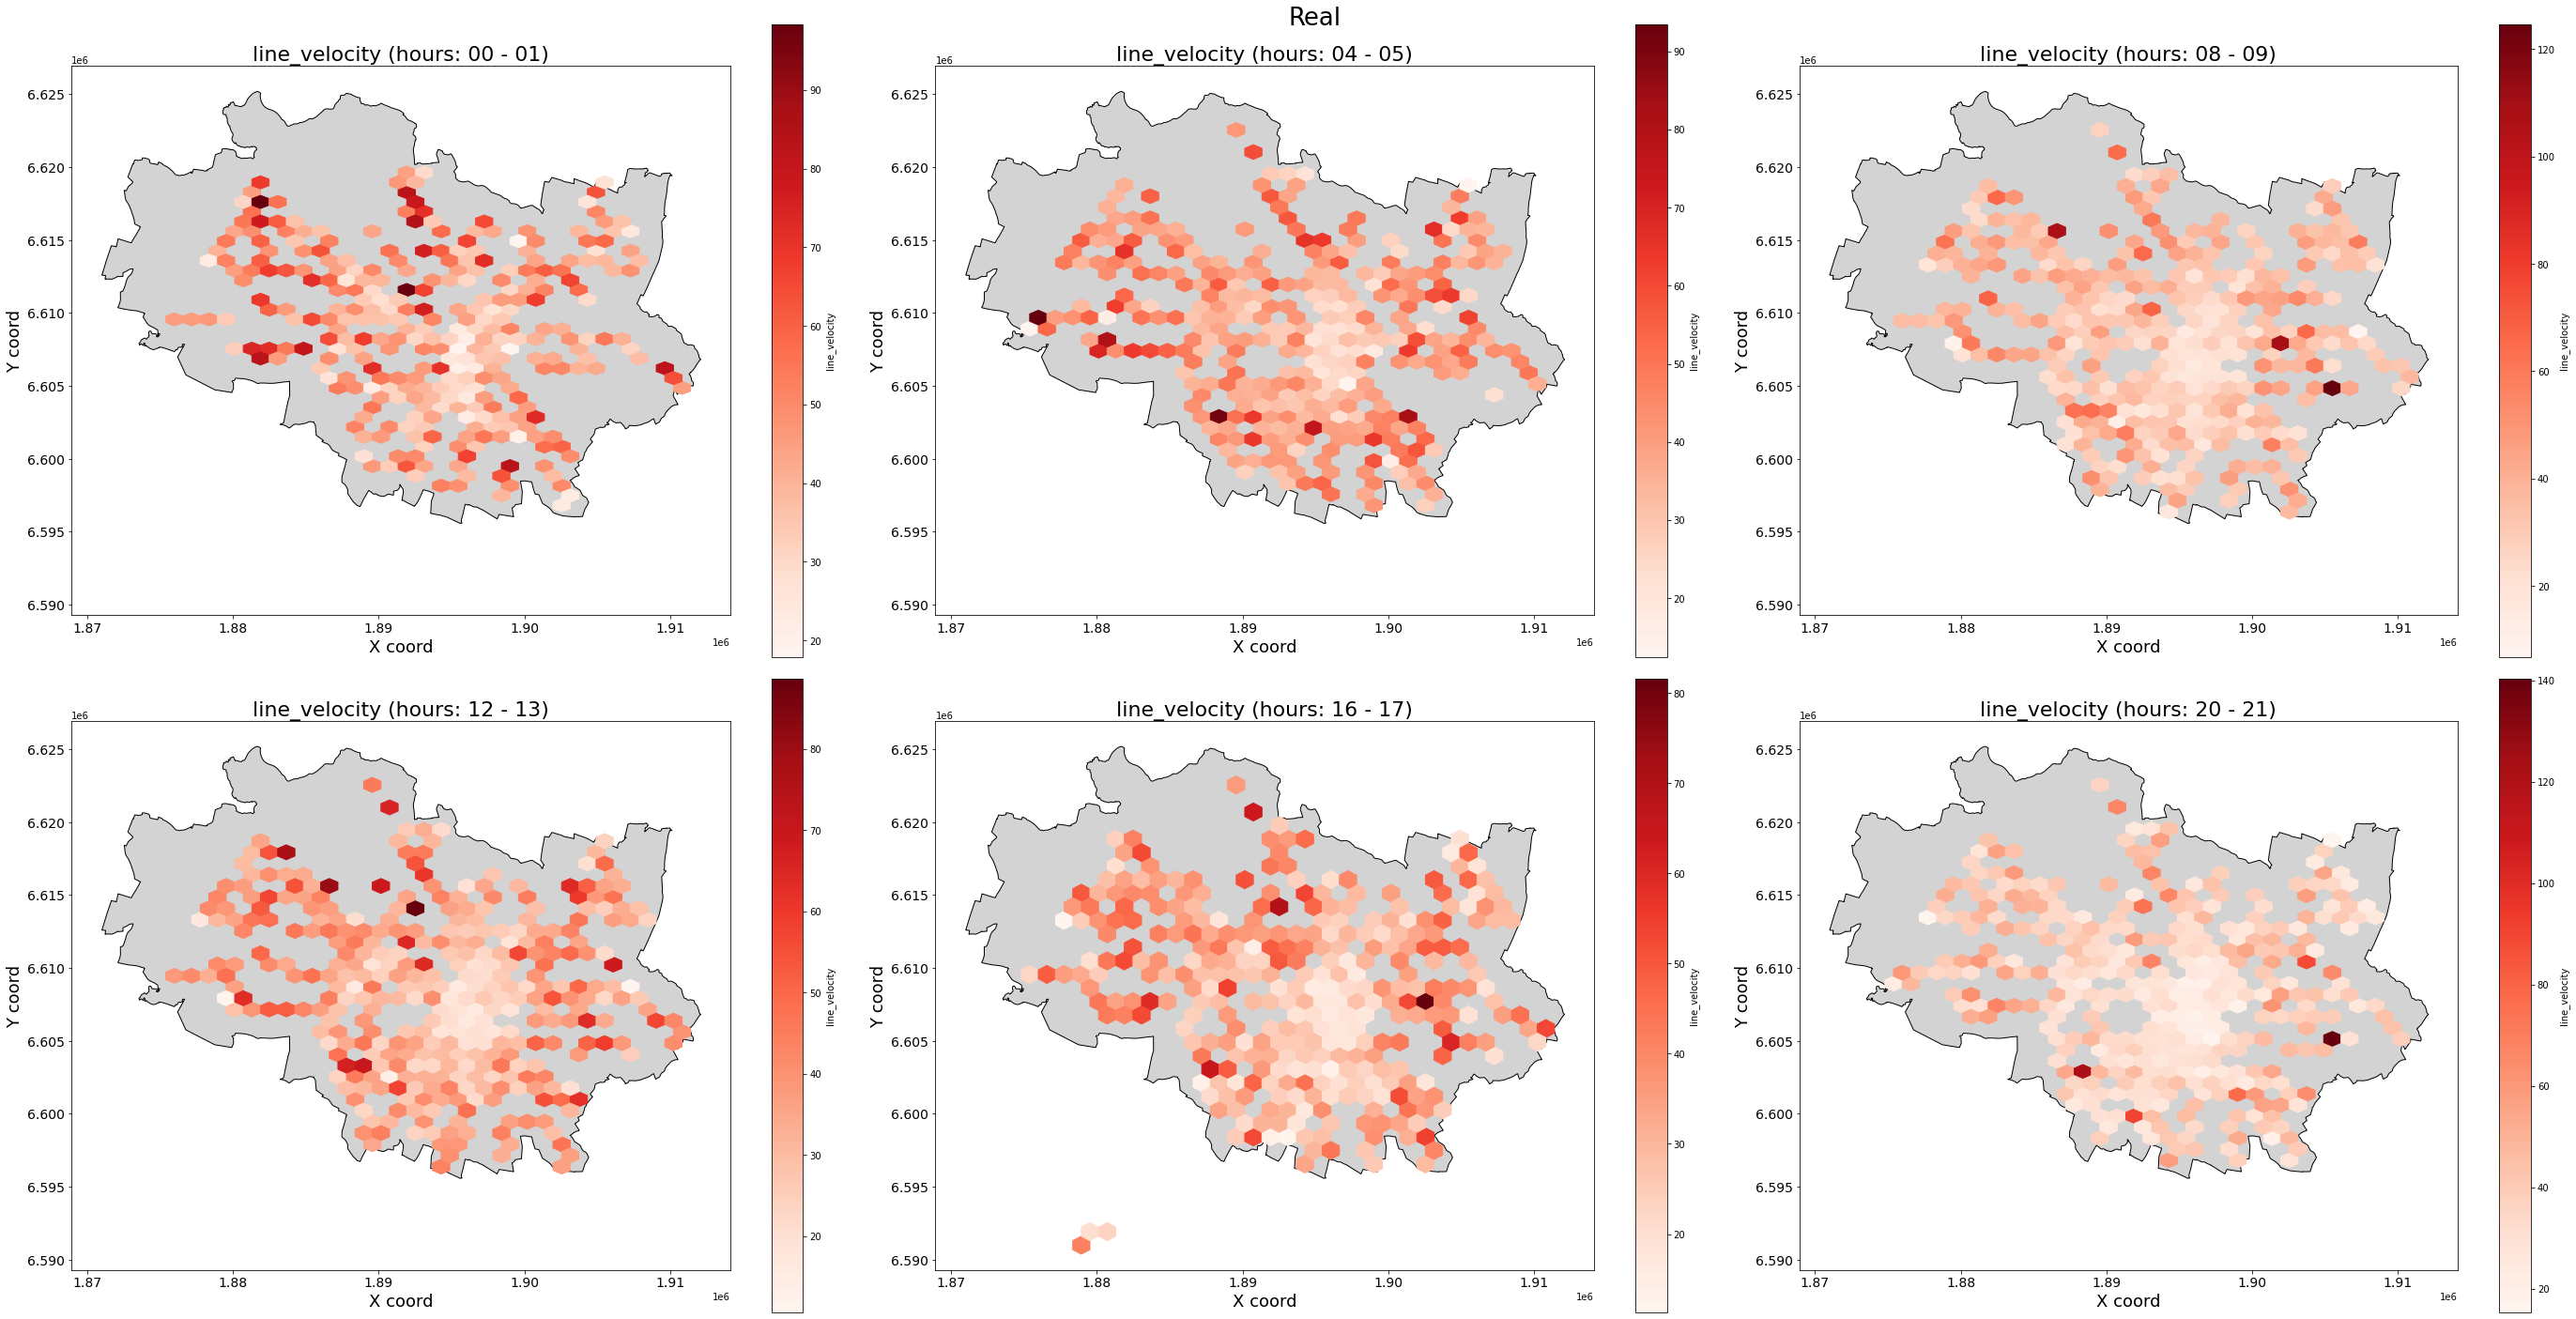

In [125]:
plot_hexbin_for_hours(wroc, _recorded_trips, value_name='line_velocity', hours=hours, title="Real")

#### Comparison

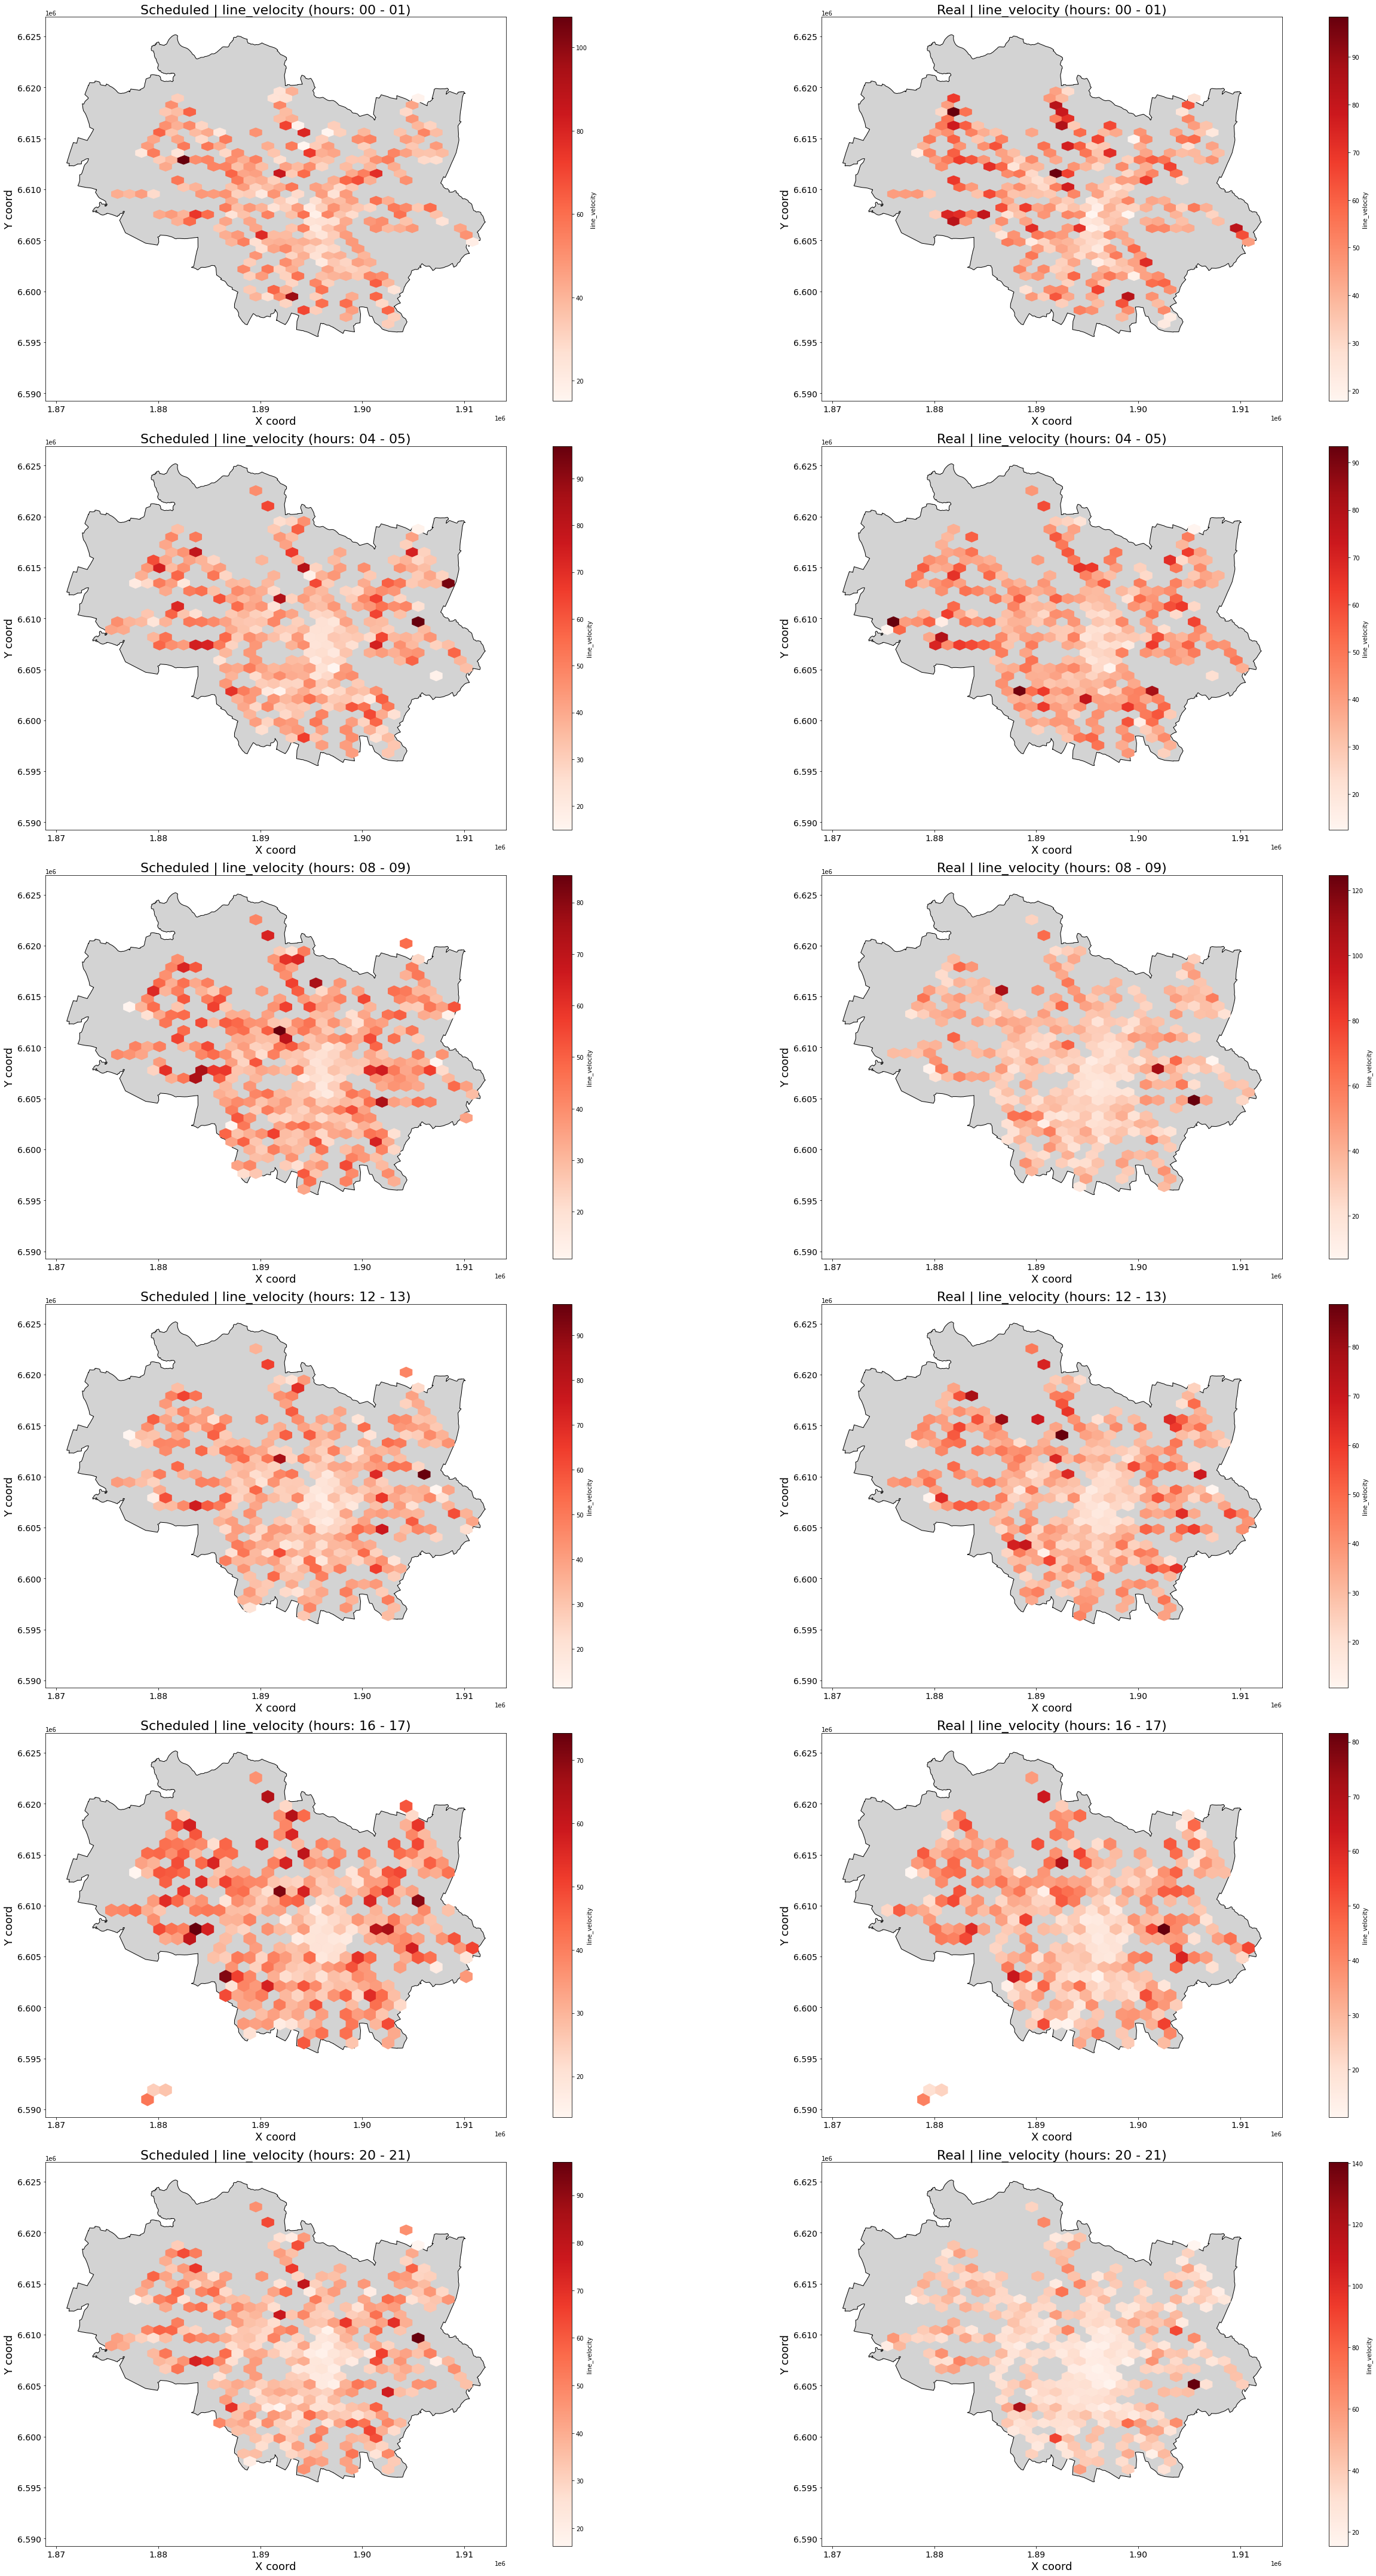

In [32]:
compare_real_and_scheduled_hexbin_for_hours(
    city_gdf=wroc, 
    real_df=_recorded_trips, 
    scheduled_df=_routes_df, 
    value_name='line_velocity', 
    hours=hours
)

### velocity (in real dist)

## **delays**

> Plots of daily and hourly delays

### Aggregated routes (bus/tram lines) for specific hours

In [129]:
merged

hour source-target  duration_planned  duration_real      delay  \
0         0     1000-1282              60.0      75.000000  15.000000   
1         0        101-99             120.0     135.000000  15.000000   
2         0     1011-4770              60.0      65.000000   5.000000   
3         0      1017-839              60.0     112.500000  52.500000   
4         0     1026-3518              60.0      55.000000  -5.000000   
...     ...           ...               ...            ...        ...   
32116    23        99-994              60.0      78.333333  18.333333   
32117    23       993-108              60.0      50.000000 -10.000000   
32118    23      994-3872              60.0      45.333333 -14.666667   
32119    23      997-4108              60.0      55.000000  -5.000000   
32120    23       999-857               0.0      40.000000  40.000000   

       relative  
0      1.250000  
1      1.125000  
2      1.083333  
3      1.875000  
4      0.916667  
...         ...  
32116  1.305556  
32117  0.833333  
32118  0.755556  
32119  0.916667  
32120       inf  

[32121 rows x 6 columns]

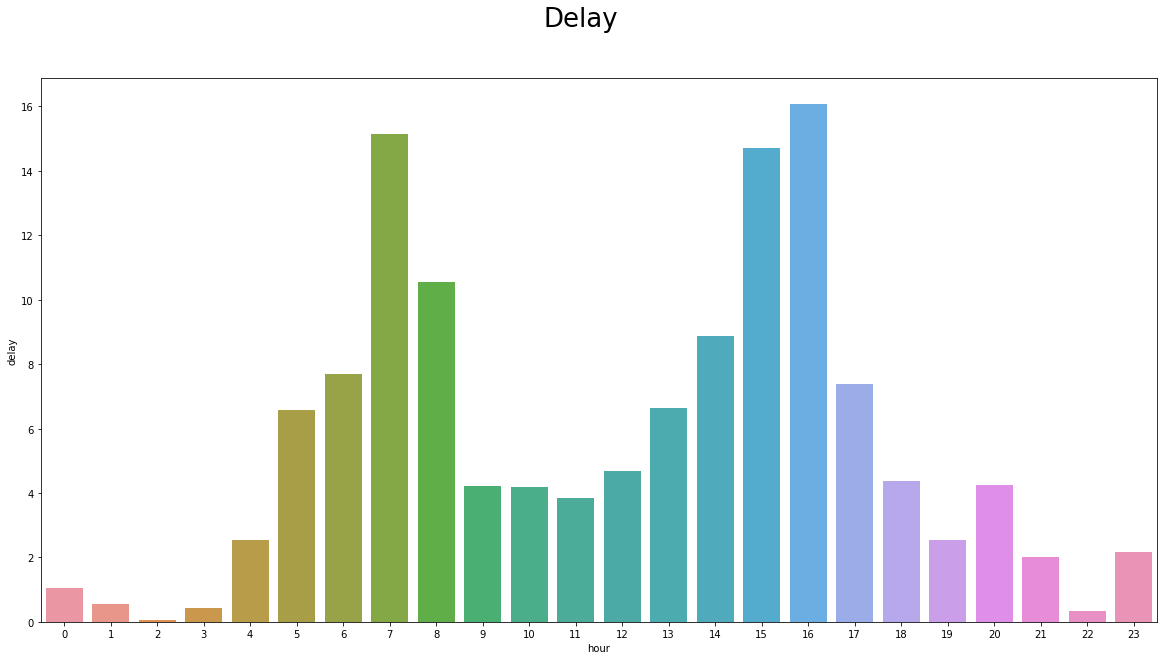

In [131]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(
    data=merged.set_index(['source-target', 'hour']).groupby('hour').mean().reset_index()[['hour', 'delay']], 
    x='hour', y='delay', ax=ax
)
    
fig.suptitle("Delay", fontsize=26)
plt.savefig("plots/mean_hour_delay.eps")

### Daily

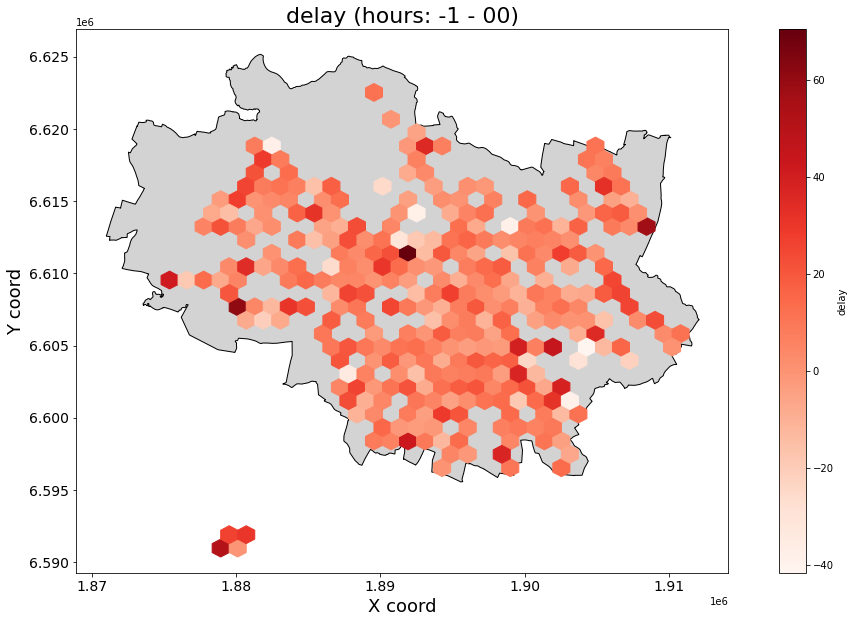

In [119]:
plot_hexbin(wroc, gpd.GeoDataFrame(daily_delays), -1, 'delay')

### Hourly

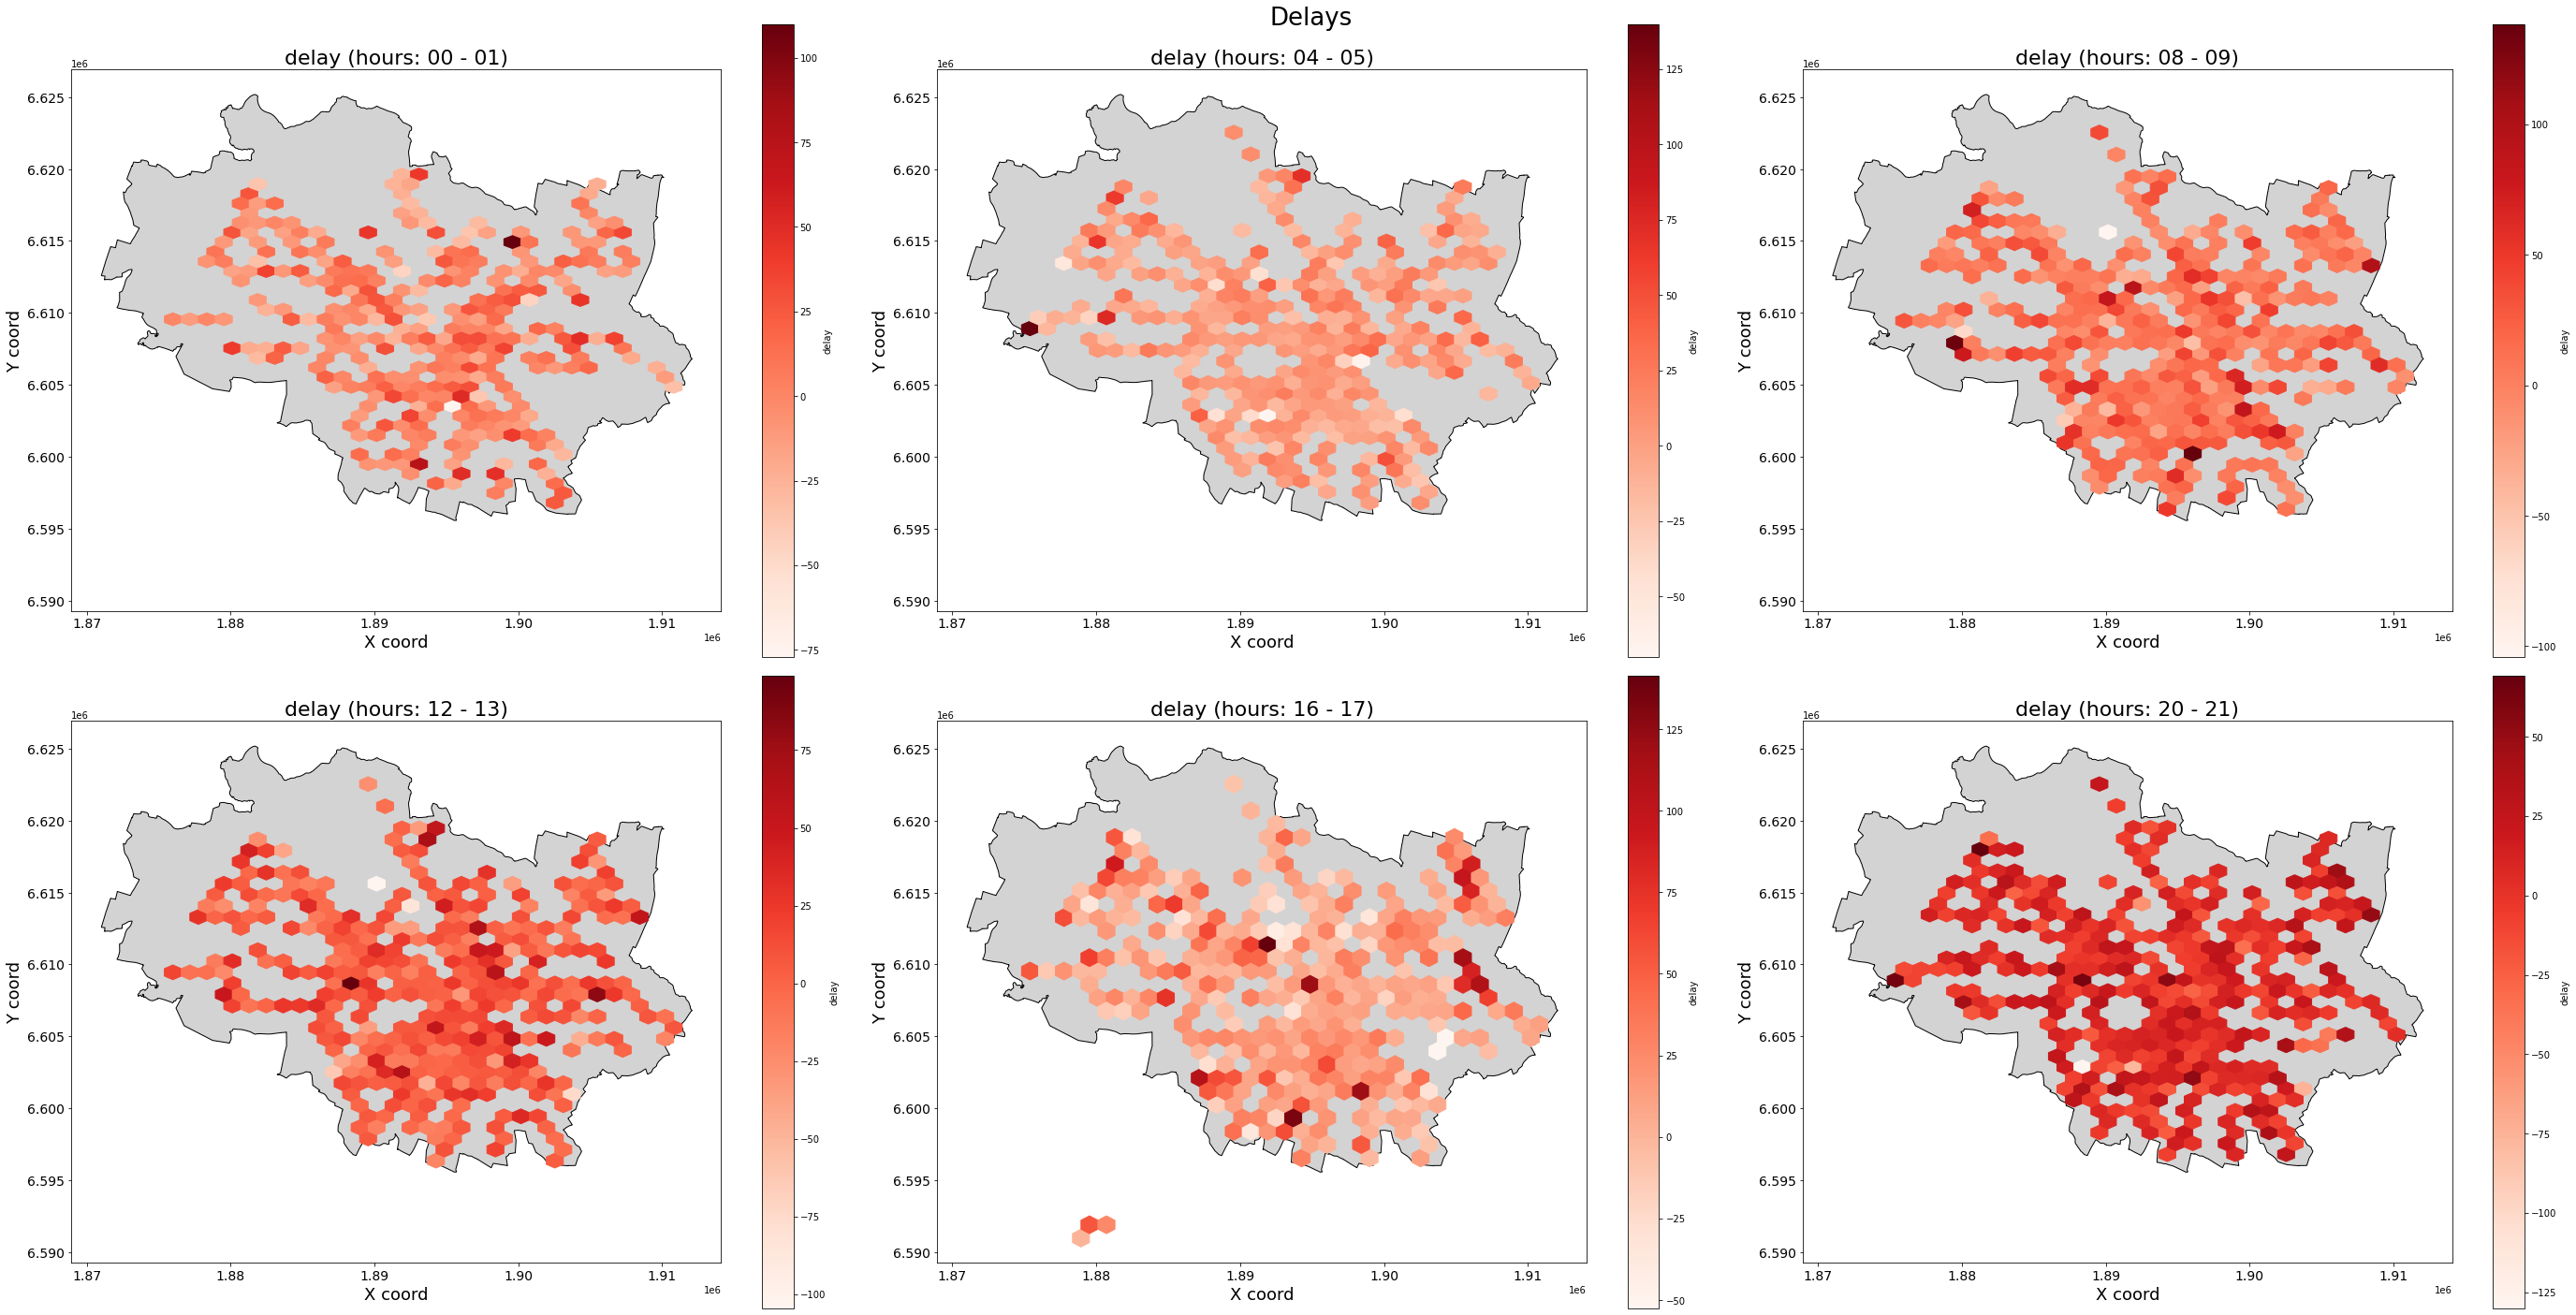

In [127]:
plot_hexbin_for_hours(wroc, hour_delays, value_name='delay', hours=hours, title="Delays")